In [1]:
from Supporting_functions import *

import matplotlib.pyplot as plt
from IPython.display import display, clear_output
import time
import skimage 

In [2]:
def image_preprocessing(img, mask, percentiles, min_v, max_v):
    
    # Image Normalization
    if percentiles[0] > 0 or percentiles[1] < 100:
        low_thres, high_thres0 = getNormalizationThresholds(img, percentiles) # low thres in whole image
        low_thres0, high_thres = getNormalizationThresholds(img * mask, percentiles) # high thres in FG
        img = remove_outliers_image(img, low_thres, high_thres)
  
    img = image_scaling(img, min_v, max_v, True)
    img = img.astype(np.uint16)
    
    return img

# Predictions for different models


In [3]:
# Define paths
# Copy all deblur model in folder deblur (manually)

modelName = 'Enhance_NucleiMembranes'

# Models
srcpath = r'/media/hmorales/Skynet/IsoNet/Models/'+modelName+'/'
path_models = srcpath+'checkpoint/saved_models/'
model_prefix = 'deblur'

# Image to test
img_src_path = srcpath+'/test_data/'
imgName = 'spim20231207_TL050_Channel1_Angle1_test'
img_test_path = os.path.join(img_src_path, imgName+'.tif')


#output dir
outdir = img_src_path+'/res_'+modelName+'/'
outsufix = 'Self_Net_output_'+modelName

# CUDA device
device = torch.device('cuda:0')
batch_size = 60

# Image Normalization
min_v = 0
max_v = 65535

thres_scale = 1.5  # threhold for simple mask for normalization
norm_percentiles = (20, 99.999)


# Create output folder
if not os.path.exists(outdir):
    os.mkdir(outdir)

     -threshold_value: 420.0
Intensity Norm  from (0 , 3315) to  (0, 65534)  



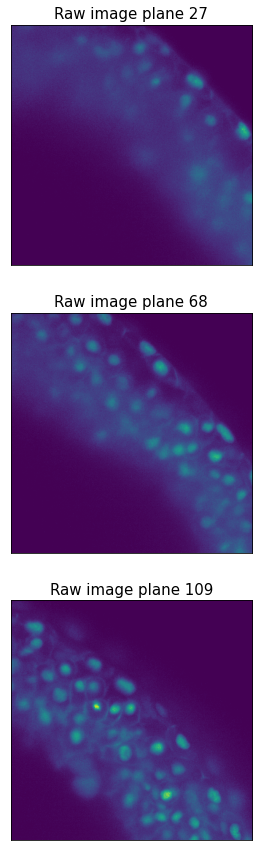

In [4]:
# Load images
raw_img  =  tifffile.imread(img_test_path).astype(np.float32)

[physical_pixel_sizeX,physical_pixel_sizeY,physical_pixel_sizeZ] = read_tiff_voxel_size(img_test_path)    
scale = physical_pixel_sizeX / physical_pixel_sizeZ

#if abs(1.0-scale) > 1e-4: 
#    raw_img = reslice(raw_img,'xy',physical_pixel_sizeX,physical_pixel_sizeZ)

mask = get_image_simple_mask(raw_img, 0, 1.0, thres_scale)  
mask =  mask.astype(np.int16)
    

# Process
img = image_preprocessing(raw_img, mask, norm_percentiles, min_v, max_v)

# Crop
#raw_img = raw_img[:,125:375,125:375]
#mask  = mask[:,125:375,125:375]
outName = os.path.join(img_src_path, imgName+'crop.tif')
tifffile.imwrite(outName,img)

image_2_test = img

# plot some planes

def show(ax, image, title):
    ax.imshow(image, cmap='viridis', vmin=0, vmax=65535)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title(title,fontsize=15)
    
fig = plt.figure(figsize=(12,15))
axs = fig.subplots(3,1)
dplane = int(0.2*img.shape[0])

for i, idx in enumerate(range(dplane,image_2_test.shape[0], int(0.5*(image_2_test.shape[0]-2*dplane))-1)):   
    subtitle0 = f"Raw image plane {idx}" 
    show(axs[i], image_2_test[idx,:,:], subtitle0)



In [5]:
# Get all models ('pkl' files) in the folder
model_names = [f for f in os.listdir(path_models) if f.endswith('.pkl') and 'deblur' in f]
model_names.sort(key=custom_sort)

# Prepare networks
deblur_net = Self_net_architecture.define_G(input_nc=1, output_nc=1, ngf=64, netG='deblur_net', device=device,use_dropout=False,norm='instance')


# Calculate for each model
for i, model_name in enumerate(model_names):

    base_name, extension = os.path.splitext(model_name)
    print(f"** Predicting model: {base_name}")
    start_time = time.time()  # Record the start time    
    img = image_2_test
    model_path = os.path.join(path_models,model_name);

    # Load Model
    deblur_net.load_state_dict(torch.load(model_path))
    # Predict image
    fusion_stack = predict_stack(img,deblur_net,min_v, max_v, device, batch_size, np.float32)
    
    #print(fusion_stack.dtype)
    #fusion_stack = image_scaling(fusion_stack,min_v, max_v, True)
    fusion_stack = fusion_stack.astype(np.uint16)
    
    #fusion_stack  = image_preprocessing(fusion_stack, mask, norm_percentiles, min_v, max_v)
    #newimg_min = np.amin(fusion_stack)
    #newimg_max = np.amax(fusion_stack)	
    #print('fusion_stack  (%d, %d) ' % (newimg_min, newimg_max), '\n')
    
    # Save result
    outName = outdir+base_name+'.tif';
    tifffile.imwrite(outName,fusion_stack)
    
    elapsed_time = time.time() - start_time
    print(f"Elapsed Time: {elapsed_time:.4f} seconds, model: {model_name}")


initialize network with normal
** Predicting model: deblur_net_1_7200


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.20s/ planes]


Elapsed Time: 5.1154 seconds, model: deblur_net_1_7200.pkl
** Predicting model: deblur_net_1_14400


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.05s/ planes]


Elapsed Time: 2.9505 seconds, model: deblur_net_1_14400.pkl
** Predicting model: deblur_net_1_21600


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.05s/ planes]


Elapsed Time: 2.9526 seconds, model: deblur_net_1_21600.pkl
** Predicting model: deblur_net_1_28800


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.06s/ planes]


Elapsed Time: 2.9959 seconds, model: deblur_net_1_28800.pkl
** Predicting model: deblur_net_1_36000


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.06s/ planes]


Elapsed Time: 2.9966 seconds, model: deblur_net_1_36000.pkl
** Predicting model: deblur_net_1_43200


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.06s/ planes]


Elapsed Time: 3.0037 seconds, model: deblur_net_1_43200.pkl
** Predicting model: deblur_net_1_50400


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.06s/ planes]


Elapsed Time: 3.0014 seconds, model: deblur_net_1_50400.pkl
** Predicting model: deblur_net_1_57600


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.07s/ planes]


Elapsed Time: 3.0080 seconds, model: deblur_net_1_57600.pkl
** Predicting model: deblur_net_1_64800


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.07s/ planes]


Elapsed Time: 3.0062 seconds, model: deblur_net_1_64800.pkl
** Predicting model: deblur_net_1_72000


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.07s/ planes]


Elapsed Time: 3.0086 seconds, model: deblur_net_1_72000.pkl
** Predicting model: deblur_net_2_7200


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.08s/ planes]


Elapsed Time: 3.0493 seconds, model: deblur_net_2_7200.pkl
** Predicting model: deblur_net_2_14400


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.07s/ planes]


Elapsed Time: 3.0072 seconds, model: deblur_net_2_14400.pkl
** Predicting model: deblur_net_2_21600


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.07s/ planes]


Elapsed Time: 3.0244 seconds, model: deblur_net_2_21600.pkl
** Predicting model: deblur_net_2_28800


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.07s/ planes]


Elapsed Time: 3.0176 seconds, model: deblur_net_2_28800.pkl
** Predicting model: deblur_net_2_36000


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.07s/ planes]


Elapsed Time: 3.0162 seconds, model: deblur_net_2_36000.pkl
** Predicting model: deblur_net_2_43200


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.07s/ planes]


Elapsed Time: 3.0234 seconds, model: deblur_net_2_43200.pkl
** Predicting model: deblur_net_2_50400


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.07s/ planes]


Elapsed Time: 3.0239 seconds, model: deblur_net_2_50400.pkl
** Predicting model: deblur_net_2_57600


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.08s/ planes]


Elapsed Time: 3.0368 seconds, model: deblur_net_2_57600.pkl
** Predicting model: deblur_net_2_64800


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.09s/ planes]


Elapsed Time: 3.0603 seconds, model: deblur_net_2_64800.pkl
** Predicting model: deblur_net_2_72000


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.07s/ planes]


Elapsed Time: 3.0491 seconds, model: deblur_net_2_72000.pkl
** Predicting model: deblur_net_3_7200


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.07s/ planes]


Elapsed Time: 3.0302 seconds, model: deblur_net_3_7200.pkl
** Predicting model: deblur_net_3_14400


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.07s/ planes]


Elapsed Time: 3.0258 seconds, model: deblur_net_3_14400.pkl
** Predicting model: deblur_net_3_21600


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.07s/ planes]


Elapsed Time: 3.0260 seconds, model: deblur_net_3_21600.pkl
** Predicting model: deblur_net_3_28800


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.07s/ planes]


Elapsed Time: 3.0393 seconds, model: deblur_net_3_28800.pkl
** Predicting model: deblur_net_3_36000


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.07s/ planes]


Elapsed Time: 3.0258 seconds, model: deblur_net_3_36000.pkl
** Predicting model: deblur_net_3_43200


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.07s/ planes]


Elapsed Time: 3.0253 seconds, model: deblur_net_3_43200.pkl
** Predicting model: deblur_net_3_50400


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.08s/ planes]


Elapsed Time: 3.0406 seconds, model: deblur_net_3_50400.pkl
** Predicting model: deblur_net_3_57600


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.07s/ planes]


Elapsed Time: 3.0335 seconds, model: deblur_net_3_57600.pkl
** Predicting model: deblur_net_3_64800


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.08s/ planes]


Elapsed Time: 3.0469 seconds, model: deblur_net_3_64800.pkl
** Predicting model: deblur_net_3_72000


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.07s/ planes]


Elapsed Time: 3.0349 seconds, model: deblur_net_3_72000.pkl
** Predicting model: deblur_net_4_7200


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.08s/ planes]


Elapsed Time: 3.0365 seconds, model: deblur_net_4_7200.pkl
** Predicting model: deblur_net_4_14400


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.08s/ planes]


Elapsed Time: 3.0364 seconds, model: deblur_net_4_14400.pkl
** Predicting model: deblur_net_4_21600


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.09s/ planes]


Elapsed Time: 3.0664 seconds, model: deblur_net_4_21600.pkl
** Predicting model: deblur_net_4_28800


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.08s/ planes]


Elapsed Time: 3.0466 seconds, model: deblur_net_4_28800.pkl
** Predicting model: deblur_net_4_36000


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.09s/ planes]


Elapsed Time: 3.0556 seconds, model: deblur_net_4_36000.pkl
** Predicting model: deblur_net_4_43200


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.08s/ planes]


Elapsed Time: 3.0395 seconds, model: deblur_net_4_43200.pkl
** Predicting model: deblur_net_4_50400


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.07s/ planes]


Elapsed Time: 3.0578 seconds, model: deblur_net_4_50400.pkl
** Predicting model: deblur_net_4_57600


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.07s/ planes]


Elapsed Time: 3.0307 seconds, model: deblur_net_4_57600.pkl
** Predicting model: deblur_net_4_64800


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.08s/ planes]


Elapsed Time: 3.0540 seconds, model: deblur_net_4_64800.pkl
** Predicting model: deblur_net_4_72000


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.08s/ planes]


Elapsed Time: 3.0480 seconds, model: deblur_net_4_72000.pkl
** Predicting model: deblur_net_5_7200


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.08s/ planes]


Elapsed Time: 3.0432 seconds, model: deblur_net_5_7200.pkl
** Predicting model: deblur_net_5_14400


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.08s/ planes]


Elapsed Time: 3.0797 seconds, model: deblur_net_5_14400.pkl
** Predicting model: deblur_net_5_21600


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.08s/ planes]


Elapsed Time: 3.0451 seconds, model: deblur_net_5_21600.pkl
** Predicting model: deblur_net_5_28800


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.07s/ planes]


Elapsed Time: 3.0518 seconds, model: deblur_net_5_28800.pkl
** Predicting model: deblur_net_5_36000


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.08s/ planes]


Elapsed Time: 3.0422 seconds, model: deblur_net_5_36000.pkl
** Predicting model: deblur_net_5_43200


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.08s/ planes]


Elapsed Time: 3.0417 seconds, model: deblur_net_5_43200.pkl
** Predicting model: deblur_net_5_50400


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.07s/ planes]


Elapsed Time: 3.0286 seconds, model: deblur_net_5_50400.pkl
** Predicting model: deblur_net_5_57600


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.08s/ planes]


Elapsed Time: 3.0389 seconds, model: deblur_net_5_57600.pkl
** Predicting model: deblur_net_5_64800


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.08s/ planes]


Elapsed Time: 3.0405 seconds, model: deblur_net_5_64800.pkl
** Predicting model: deblur_net_5_72000


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.08s/ planes]


Elapsed Time: 3.0379 seconds, model: deblur_net_5_72000.pkl
** Predicting model: deblur_net_6_7200


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.08s/ planes]


Elapsed Time: 3.0428 seconds, model: deblur_net_6_7200.pkl
** Predicting model: deblur_net_6_14400


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.11s/ planes]


Elapsed Time: 3.0957 seconds, model: deblur_net_6_14400.pkl
** Predicting model: deblur_net_6_21600


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.12s/ planes]


Elapsed Time: 3.0960 seconds, model: deblur_net_6_21600.pkl
** Predicting model: deblur_net_6_28800


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.12s/ planes]


Elapsed Time: 3.1346 seconds, model: deblur_net_6_28800.pkl
** Predicting model: deblur_net_6_36000


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.11s/ planes]


Elapsed Time: 3.1067 seconds, model: deblur_net_6_36000.pkl
** Predicting model: deblur_net_6_43200


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.12s/ planes]


Elapsed Time: 3.1491 seconds, model: deblur_net_6_43200.pkl
** Predicting model: deblur_net_6_50400


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.12s/ planes]


Elapsed Time: 3.0665 seconds, model: deblur_net_6_50400.pkl
** Predicting model: deblur_net_6_57600


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.10s/ planes]


Elapsed Time: 3.0905 seconds, model: deblur_net_6_57600.pkl
** Predicting model: deblur_net_6_64800


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.09s/ planes]


Elapsed Time: 3.0658 seconds, model: deblur_net_6_64800.pkl
** Predicting model: deblur_net_6_72000


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.08s/ planes]


Elapsed Time: 3.0459 seconds, model: deblur_net_6_72000.pkl
** Predicting model: deblur_net_7_7200


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.09s/ planes]


Elapsed Time: 3.0569 seconds, model: deblur_net_7_7200.pkl
** Predicting model: deblur_net_7_14400


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.09s/ planes]


Elapsed Time: 3.0514 seconds, model: deblur_net_7_14400.pkl
** Predicting model: deblur_net_7_21600


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.11s/ planes]


Elapsed Time: 3.0964 seconds, model: deblur_net_7_21600.pkl
** Predicting model: deblur_net_7_28800


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.09s/ planes]


Elapsed Time: 3.0859 seconds, model: deblur_net_7_28800.pkl
** Predicting model: deblur_net_7_36000


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.08s/ planes]


Elapsed Time: 3.0693 seconds, model: deblur_net_7_36000.pkl
** Predicting model: deblur_net_7_43200


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.08s/ planes]


Elapsed Time: 3.0588 seconds, model: deblur_net_7_43200.pkl
** Predicting model: deblur_net_7_50400


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.09s/ planes]


Elapsed Time: 3.0821 seconds, model: deblur_net_7_50400.pkl
** Predicting model: deblur_net_7_57600


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.11s/ planes]


Elapsed Time: 3.1188 seconds, model: deblur_net_7_57600.pkl
** Predicting model: deblur_net_7_64800


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.08s/ planes]


Elapsed Time: 3.0660 seconds, model: deblur_net_7_64800.pkl
** Predicting model: deblur_net_7_72000


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.08s/ planes]


Elapsed Time: 3.0779 seconds, model: deblur_net_7_72000.pkl
** Predicting model: deblur_net_8_7200


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.09s/ planes]


Elapsed Time: 3.0914 seconds, model: deblur_net_8_7200.pkl
** Predicting model: deblur_net_8_14400


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.08s/ planes]


Elapsed Time: 3.0792 seconds, model: deblur_net_8_14400.pkl
** Predicting model: deblur_net_8_21600


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.08s/ planes]


Elapsed Time: 3.0904 seconds, model: deblur_net_8_21600.pkl
** Predicting model: deblur_net_8_28800


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.08s/ planes]


Elapsed Time: 3.0604 seconds, model: deblur_net_8_28800.pkl
** Predicting model: deblur_net_8_36000


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.10s/ planes]


Elapsed Time: 3.1461 seconds, model: deblur_net_8_36000.pkl
** Predicting model: deblur_net_8_43200


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.11s/ planes]


Elapsed Time: 3.1353 seconds, model: deblur_net_8_43200.pkl
** Predicting model: deblur_net_8_50400


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.11s/ planes]


Elapsed Time: 3.1485 seconds, model: deblur_net_8_50400.pkl
** Predicting model: deblur_net_8_57600


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.09s/ planes]


Elapsed Time: 3.1041 seconds, model: deblur_net_8_57600.pkl
** Predicting model: deblur_net_8_64800


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.09s/ planes]


Elapsed Time: 3.1032 seconds, model: deblur_net_8_64800.pkl
** Predicting model: deblur_net_8_72000


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.14s/ planes]


Elapsed Time: 3.2065 seconds, model: deblur_net_8_72000.pkl
** Predicting model: deblur_net_9_7200


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.09s/ planes]


Elapsed Time: 3.0962 seconds, model: deblur_net_9_7200.pkl
** Predicting model: deblur_net_9_14400


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.11s/ planes]


Elapsed Time: 3.1198 seconds, model: deblur_net_9_14400.pkl
** Predicting model: deblur_net_9_21600


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.08s/ planes]


Elapsed Time: 3.0932 seconds, model: deblur_net_9_21600.pkl
** Predicting model: deblur_net_9_28800


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.09s/ planes]


Elapsed Time: 3.1136 seconds, model: deblur_net_9_28800.pkl
** Predicting model: deblur_net_9_36000


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.10s/ planes]


Elapsed Time: 3.1167 seconds, model: deblur_net_9_36000.pkl
** Predicting model: deblur_net_9_43200


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.09s/ planes]


Elapsed Time: 3.0899 seconds, model: deblur_net_9_43200.pkl
** Predicting model: deblur_net_9_50400


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.09s/ planes]


Elapsed Time: 3.0721 seconds, model: deblur_net_9_50400.pkl
** Predicting model: deblur_net_9_57600


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.10s/ planes]


Elapsed Time: 3.0926 seconds, model: deblur_net_9_57600.pkl
** Predicting model: deblur_net_9_64800


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.09s/ planes]


Elapsed Time: 3.0730 seconds, model: deblur_net_9_64800.pkl
** Predicting model: deblur_net_9_72000


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.09s/ planes]


Elapsed Time: 3.0860 seconds, model: deblur_net_9_72000.pkl
** Predicting model: deblur_net_10_7200


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.09s/ planes]


Elapsed Time: 3.1044 seconds, model: deblur_net_10_7200.pkl
** Predicting model: deblur_net_10_14400


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.08s/ planes]


Elapsed Time: 3.0622 seconds, model: deblur_net_10_14400.pkl
** Predicting model: deblur_net_10_21600


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.09s/ planes]


Elapsed Time: 3.1037 seconds, model: deblur_net_10_21600.pkl
** Predicting model: deblur_net_10_28800


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.09s/ planes]


Elapsed Time: 3.0793 seconds, model: deblur_net_10_28800.pkl
** Predicting model: deblur_net_10_36000


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.08s/ planes]


Elapsed Time: 3.0299 seconds, model: deblur_net_10_36000.pkl
** Predicting model: deblur_net_10_43200


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.08s/ planes]


Elapsed Time: 3.0409 seconds, model: deblur_net_10_43200.pkl
** Predicting model: deblur_net_10_50400


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.10s/ planes]


Elapsed Time: 3.1048 seconds, model: deblur_net_10_50400.pkl
** Predicting model: deblur_net_10_57600


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.10s/ planes]


Elapsed Time: 3.0635 seconds, model: deblur_net_10_57600.pkl
** Predicting model: deblur_net_10_64800


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.10s/ planes]


Elapsed Time: 3.1166 seconds, model: deblur_net_10_64800.pkl
** Predicting model: deblur_net_10_72000


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.12s/ planes]


Elapsed Time: 3.1737 seconds, model: deblur_net_10_72000.pkl
** Predicting model: deblur_net_11_7200


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.12s/ planes]


Elapsed Time: 3.1382 seconds, model: deblur_net_11_7200.pkl
** Predicting model: deblur_net_11_14400


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.11s/ planes]


Elapsed Time: 3.1416 seconds, model: deblur_net_11_14400.pkl
** Predicting model: deblur_net_11_21600


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.12s/ planes]


Elapsed Time: 3.1569 seconds, model: deblur_net_11_21600.pkl
** Predicting model: deblur_net_11_28800


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.10s/ planes]


Elapsed Time: 3.0974 seconds, model: deblur_net_11_28800.pkl
** Predicting model: deblur_net_11_36000


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.10s/ planes]


Elapsed Time: 3.1169 seconds, model: deblur_net_11_36000.pkl
** Predicting model: deblur_net_11_43200


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.09s/ planes]


Elapsed Time: 2.9845 seconds, model: deblur_net_11_43200.pkl
** Predicting model: deblur_net_11_50400


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.12s/ planes]


Elapsed Time: 3.1433 seconds, model: deblur_net_11_50400.pkl
** Predicting model: deblur_net_11_57600


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.11s/ planes]


Elapsed Time: 3.1194 seconds, model: deblur_net_11_57600.pkl
** Predicting model: deblur_net_11_64800


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.10s/ planes]


Elapsed Time: 3.0957 seconds, model: deblur_net_11_64800.pkl
** Predicting model: deblur_net_11_72000


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.11s/ planes]


Elapsed Time: 3.1290 seconds, model: deblur_net_11_72000.pkl
** Predicting model: deblur_net_12_7200


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.13s/ planes]


Elapsed Time: 3.1510 seconds, model: deblur_net_12_7200.pkl
** Predicting model: deblur_net_12_14400


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.15s/ planes]


Elapsed Time: 3.1979 seconds, model: deblur_net_12_14400.pkl
** Predicting model: deblur_net_12_21600


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.13s/ planes]


Elapsed Time: 3.1535 seconds, model: deblur_net_12_21600.pkl
** Predicting model: deblur_net_12_28800


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.11s/ planes]


Elapsed Time: 3.1264 seconds, model: deblur_net_12_28800.pkl
** Predicting model: deblur_net_12_36000


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.13s/ planes]


Elapsed Time: 3.1653 seconds, model: deblur_net_12_36000.pkl
** Predicting model: deblur_net_12_43200


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.13s/ planes]


Elapsed Time: 3.1700 seconds, model: deblur_net_12_43200.pkl
** Predicting model: deblur_net_12_50400


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.11s/ planes]


Elapsed Time: 3.1136 seconds, model: deblur_net_12_50400.pkl
** Predicting model: deblur_net_12_57600


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.09s/ planes]


Elapsed Time: 3.0824 seconds, model: deblur_net_12_57600.pkl
** Predicting model: deblur_net_12_64800


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.09s/ planes]


Elapsed Time: 3.0904 seconds, model: deblur_net_12_64800.pkl
** Predicting model: deblur_net_12_72000


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.12s/ planes]


Elapsed Time: 3.1588 seconds, model: deblur_net_12_72000.pkl
** Predicting model: deblur_net_13_7200


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.14s/ planes]


Elapsed Time: 3.1969 seconds, model: deblur_net_13_7200.pkl
** Predicting model: deblur_net_13_14400


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.11s/ planes]


Elapsed Time: 2.9894 seconds, model: deblur_net_13_14400.pkl
** Predicting model: deblur_net_13_21600


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.30s/ planes]


Elapsed Time: 3.4300 seconds, model: deblur_net_13_21600.pkl
** Predicting model: deblur_net_13_28800


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.15s/ planes]


Elapsed Time: 3.0841 seconds, model: deblur_net_13_28800.pkl
** Predicting model: deblur_net_13_36000


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.13s/ planes]


Elapsed Time: 3.1148 seconds, model: deblur_net_13_36000.pkl
** Predicting model: deblur_net_13_43200


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.28s/ planes]


Elapsed Time: 3.2806 seconds, model: deblur_net_13_43200.pkl
** Predicting model: deblur_net_13_50400


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.09s/ planes]


Elapsed Time: 2.9422 seconds, model: deblur_net_13_50400.pkl
** Predicting model: deblur_net_13_57600


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.11s/ planes]


Elapsed Time: 3.0378 seconds, model: deblur_net_13_57600.pkl
** Predicting model: deblur_net_13_64800


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.58s/ planes]


Elapsed Time: 3.9941 seconds, model: deblur_net_13_64800.pkl
** Predicting model: deblur_net_13_72000


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.08s/ planes]


Elapsed Time: 2.9397 seconds, model: deblur_net_13_72000.pkl
** Predicting model: deblur_net_14_7200


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.09s/ planes]


Elapsed Time: 2.9258 seconds, model: deblur_net_14_7200.pkl
** Predicting model: deblur_net_14_14400


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.20s/ planes]


Elapsed Time: 3.2791 seconds, model: deblur_net_14_14400.pkl
** Predicting model: deblur_net_14_21600


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.08s/ planes]


Elapsed Time: 3.0679 seconds, model: deblur_net_14_21600.pkl
** Predicting model: deblur_net_14_28800


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.08s/ planes]


Elapsed Time: 3.0298 seconds, model: deblur_net_14_28800.pkl
** Predicting model: deblur_net_14_36000


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.09s/ planes]


Elapsed Time: 3.0766 seconds, model: deblur_net_14_36000.pkl
** Predicting model: deblur_net_14_43200


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.09s/ planes]


Elapsed Time: 3.0753 seconds, model: deblur_net_14_43200.pkl
** Predicting model: deblur_net_14_50400


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.09s/ planes]


Elapsed Time: 3.0749 seconds, model: deblur_net_14_50400.pkl
** Predicting model: deblur_net_14_57600


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.14s/ planes]


Elapsed Time: 3.1834 seconds, model: deblur_net_14_57600.pkl
** Predicting model: deblur_net_14_64800


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.09s/ planes]


Elapsed Time: 3.0980 seconds, model: deblur_net_14_64800.pkl
** Predicting model: deblur_net_14_72000


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.84s/ planes]


Elapsed Time: 4.4764 seconds, model: deblur_net_14_72000.pkl
** Predicting model: deblur_net_15_7200


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.09s/ planes]


Elapsed Time: 3.0081 seconds, model: deblur_net_15_7200.pkl
** Predicting model: deblur_net_15_14400


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.08s/ planes]


Elapsed Time: 2.9574 seconds, model: deblur_net_15_14400.pkl
** Predicting model: deblur_net_15_21600


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.08s/ planes]


Elapsed Time: 2.9226 seconds, model: deblur_net_15_21600.pkl
** Predicting model: deblur_net_15_28800


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.08s/ planes]


Elapsed Time: 2.9251 seconds, model: deblur_net_15_28800.pkl
** Predicting model: deblur_net_15_36000


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.10s/ planes]


Elapsed Time: 2.9546 seconds, model: deblur_net_15_36000.pkl
** Predicting model: deblur_net_15_43200


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.09s/ planes]


Elapsed Time: 2.9255 seconds, model: deblur_net_15_43200.pkl
** Predicting model: deblur_net_15_50400


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.08s/ planes]


Elapsed Time: 2.9176 seconds, model: deblur_net_15_50400.pkl
** Predicting model: deblur_net_15_57600


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.09s/ planes]


Elapsed Time: 2.9242 seconds, model: deblur_net_15_57600.pkl
** Predicting model: deblur_net_15_64800


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.15s/ planes]


Elapsed Time: 3.0575 seconds, model: deblur_net_15_64800.pkl
** Predicting model: deblur_net_15_72000


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.16s/ planes]


Elapsed Time: 3.1077 seconds, model: deblur_net_15_72000.pkl
** Predicting model: deblur_net_16_7200


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.17s/ planes]


Elapsed Time: 3.0854 seconds, model: deblur_net_16_7200.pkl
** Predicting model: deblur_net_16_14400


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.14s/ planes]


Elapsed Time: 3.0331 seconds, model: deblur_net_16_14400.pkl
** Predicting model: deblur_net_16_21600


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.14s/ planes]


Elapsed Time: 3.1073 seconds, model: deblur_net_16_21600.pkl
** Predicting model: deblur_net_16_28800


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.12s/ planes]


Elapsed Time: 3.0227 seconds, model: deblur_net_16_28800.pkl
** Predicting model: deblur_net_16_36000


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.09s/ planes]


Elapsed Time: 2.9259 seconds, model: deblur_net_16_36000.pkl
** Predicting model: deblur_net_16_43200


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.09s/ planes]


Elapsed Time: 2.9392 seconds, model: deblur_net_16_43200.pkl
** Predicting model: deblur_net_16_50400


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.11s/ planes]


Elapsed Time: 2.9795 seconds, model: deblur_net_16_50400.pkl
** Predicting model: deblur_net_16_57600


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.09s/ planes]


Elapsed Time: 2.9255 seconds, model: deblur_net_16_57600.pkl
** Predicting model: deblur_net_16_64800


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.10s/ planes]


Elapsed Time: 2.9731 seconds, model: deblur_net_16_64800.pkl
** Predicting model: deblur_net_16_72000


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.14s/ planes]


Elapsed Time: 3.1091 seconds, model: deblur_net_16_72000.pkl
** Predicting model: deblur_net_17_7200


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.15s/ planes]


Elapsed Time: 2.9957 seconds, model: deblur_net_17_7200.pkl
** Predicting model: deblur_net_17_14400


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.15s/ planes]


Elapsed Time: 3.0628 seconds, model: deblur_net_17_14400.pkl
** Predicting model: deblur_net_17_21600


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.21s/ planes]


Elapsed Time: 3.1993 seconds, model: deblur_net_17_21600.pkl
** Predicting model: deblur_net_17_28800


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.15s/ planes]


Elapsed Time: 3.0917 seconds, model: deblur_net_17_28800.pkl
** Predicting model: deblur_net_17_36000


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.16s/ planes]


Elapsed Time: 3.0711 seconds, model: deblur_net_17_36000.pkl
** Predicting model: deblur_net_17_43200


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.28s/ planes]


Elapsed Time: 3.3351 seconds, model: deblur_net_17_43200.pkl
** Predicting model: deblur_net_17_50400


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.14s/ planes]


Elapsed Time: 3.0301 seconds, model: deblur_net_17_50400.pkl
** Predicting model: deblur_net_17_57600


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.53s/ planes]


Elapsed Time: 3.8329 seconds, model: deblur_net_17_57600.pkl
** Predicting model: deblur_net_17_64800


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.08s/ planes]


Elapsed Time: 3.0139 seconds, model: deblur_net_17_64800.pkl
** Predicting model: deblur_net_17_72000


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.27s/ planes]


Elapsed Time: 3.2891 seconds, model: deblur_net_17_72000.pkl
** Predicting model: deblur_net_18_7200


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.09s/ planes]


Elapsed Time: 2.9360 seconds, model: deblur_net_18_7200.pkl
** Predicting model: deblur_net_18_14400


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.08s/ planes]


Elapsed Time: 3.0007 seconds, model: deblur_net_18_14400.pkl
** Predicting model: deblur_net_18_21600


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.09s/ planes]


Elapsed Time: 2.9296 seconds, model: deblur_net_18_21600.pkl
** Predicting model: deblur_net_18_28800


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.10s/ planes]


Elapsed Time: 2.9735 seconds, model: deblur_net_18_28800.pkl
** Predicting model: deblur_net_18_36000


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.09s/ planes]


Elapsed Time: 2.9362 seconds, model: deblur_net_18_36000.pkl
** Predicting model: deblur_net_18_43200


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.09s/ planes]


Elapsed Time: 3.0001 seconds, model: deblur_net_18_43200.pkl
** Predicting model: deblur_net_18_50400


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.09s/ planes]


Elapsed Time: 2.9202 seconds, model: deblur_net_18_50400.pkl
** Predicting model: deblur_net_18_57600


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.09s/ planes]


Elapsed Time: 2.9409 seconds, model: deblur_net_18_57600.pkl
** Predicting model: deblur_net_18_64800


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.09s/ planes]


Elapsed Time: 2.9378 seconds, model: deblur_net_18_64800.pkl
** Predicting model: deblur_net_18_72000


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.11s/ planes]


Elapsed Time: 2.9831 seconds, model: deblur_net_18_72000.pkl
** Predicting model: deblur_net_19_7200


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.09s/ planes]


Elapsed Time: 3.0053 seconds, model: deblur_net_19_7200.pkl
** Predicting model: deblur_net_19_14400


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.33s/ planes]


Elapsed Time: 3.4077 seconds, model: deblur_net_19_14400.pkl
** Predicting model: deblur_net_19_21600


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.08s/ planes]


Elapsed Time: 2.9557 seconds, model: deblur_net_19_21600.pkl
** Predicting model: deblur_net_19_28800


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.48s/ planes]


Elapsed Time: 3.7268 seconds, model: deblur_net_19_28800.pkl
** Predicting model: deblur_net_19_36000


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.09s/ planes]


Elapsed Time: 2.9956 seconds, model: deblur_net_19_36000.pkl
** Predicting model: deblur_net_19_43200


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.08s/ planes]


Elapsed Time: 2.9325 seconds, model: deblur_net_19_43200.pkl
** Predicting model: deblur_net_19_50400


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.08s/ planes]


Elapsed Time: 2.9255 seconds, model: deblur_net_19_50400.pkl
** Predicting model: deblur_net_19_57600


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.08s/ planes]


Elapsed Time: 2.9175 seconds, model: deblur_net_19_57600.pkl
** Predicting model: deblur_net_19_64800


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.11s/ planes]


Elapsed Time: 2.9811 seconds, model: deblur_net_19_64800.pkl
** Predicting model: deblur_net_19_72000


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.11s/ planes]


Elapsed Time: 3.0504 seconds, model: deblur_net_19_72000.pkl
** Predicting model: deblur_net_20_7200


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.14s/ planes]


Elapsed Time: 2.9708 seconds, model: deblur_net_20_7200.pkl
** Predicting model: deblur_net_20_14400


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.14s/ planes]


Elapsed Time: 3.0253 seconds, model: deblur_net_20_14400.pkl
** Predicting model: deblur_net_20_21600


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.11s/ planes]


Elapsed Time: 2.9754 seconds, model: deblur_net_20_21600.pkl
** Predicting model: deblur_net_20_28800


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.14s/ planes]


Elapsed Time: 3.0260 seconds, model: deblur_net_20_28800.pkl
** Predicting model: deblur_net_20_36000


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.10s/ planes]


Elapsed Time: 3.0601 seconds, model: deblur_net_20_36000.pkl
** Predicting model: deblur_net_20_43200


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.08s/ planes]


Elapsed Time: 2.9561 seconds, model: deblur_net_20_43200.pkl
** Predicting model: deblur_net_20_50400


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.08s/ planes]


Elapsed Time: 2.9339 seconds, model: deblur_net_20_50400.pkl
** Predicting model: deblur_net_20_57600


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.08s/ planes]


Elapsed Time: 2.9160 seconds, model: deblur_net_20_57600.pkl
** Predicting model: deblur_net_20_64800


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.09s/ planes]


Elapsed Time: 2.9221 seconds, model: deblur_net_20_64800.pkl
** Predicting model: deblur_net_20_72000


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.10s/ planes]


Elapsed Time: 2.9693 seconds, model: deblur_net_20_72000.pkl
** Predicting model: deblur_net_21_7200


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.10s/ planes]


Elapsed Time: 2.9518 seconds, model: deblur_net_21_7200.pkl
** Predicting model: deblur_net_21_14400


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.11s/ planes]


Elapsed Time: 2.9732 seconds, model: deblur_net_21_14400.pkl
** Predicting model: deblur_net_21_21600


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.10s/ planes]


Elapsed Time: 2.9568 seconds, model: deblur_net_21_21600.pkl
** Predicting model: deblur_net_21_28800


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.12s/ planes]


Elapsed Time: 3.0145 seconds, model: deblur_net_21_28800.pkl
** Predicting model: deblur_net_21_36000


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.08s/ planes]


Elapsed Time: 2.9409 seconds, model: deblur_net_21_36000.pkl
** Predicting model: deblur_net_21_43200


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.08s/ planes]


Elapsed Time: 2.9708 seconds, model: deblur_net_21_43200.pkl
** Predicting model: deblur_net_21_50400


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.08s/ planes]


Elapsed Time: 2.9677 seconds, model: deblur_net_21_50400.pkl
** Predicting model: deblur_net_21_57600


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.08s/ planes]


Elapsed Time: 2.9197 seconds, model: deblur_net_21_57600.pkl
** Predicting model: deblur_net_21_64800


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.57s/ planes]


Elapsed Time: 3.9990 seconds, model: deblur_net_21_64800.pkl
** Predicting model: deblur_net_21_72000


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.08s/ planes]


Elapsed Time: 2.9448 seconds, model: deblur_net_21_72000.pkl
** Predicting model: deblur_net_22_7200


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.08s/ planes]


Elapsed Time: 2.9804 seconds, model: deblur_net_22_7200.pkl
** Predicting model: deblur_net_22_14400


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.09s/ planes]


Elapsed Time: 3.0668 seconds, model: deblur_net_22_14400.pkl
** Predicting model: deblur_net_22_21600


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.08s/ planes]


Elapsed Time: 3.0452 seconds, model: deblur_net_22_21600.pkl
** Predicting model: deblur_net_22_28800


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.16s/ planes]


Elapsed Time: 3.2248 seconds, model: deblur_net_22_28800.pkl
** Predicting model: deblur_net_22_36000


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.09s/ planes]


Elapsed Time: 3.0702 seconds, model: deblur_net_22_36000.pkl
** Predicting model: deblur_net_22_43200


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.08s/ planes]


Elapsed Time: 2.9216 seconds, model: deblur_net_22_43200.pkl
** Predicting model: deblur_net_22_50400


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.08s/ planes]


Elapsed Time: 2.9144 seconds, model: deblur_net_22_50400.pkl
** Predicting model: deblur_net_22_57600


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.08s/ planes]


Elapsed Time: 2.9227 seconds, model: deblur_net_22_57600.pkl
** Predicting model: deblur_net_22_64800


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.11s/ planes]


Elapsed Time: 2.9712 seconds, model: deblur_net_22_64800.pkl
** Predicting model: deblur_net_22_72000


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.08s/ planes]


Elapsed Time: 2.9297 seconds, model: deblur_net_22_72000.pkl
** Predicting model: deblur_net_23_7200


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.11s/ planes]


Elapsed Time: 3.0013 seconds, model: deblur_net_23_7200.pkl
** Predicting model: deblur_net_23_14400


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.09s/ planes]


Elapsed Time: 2.9398 seconds, model: deblur_net_23_14400.pkl
** Predicting model: deblur_net_23_21600


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.13s/ planes]


Elapsed Time: 3.0138 seconds, model: deblur_net_23_21600.pkl
** Predicting model: deblur_net_23_28800


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.16s/ planes]


Elapsed Time: 3.0786 seconds, model: deblur_net_23_28800.pkl
** Predicting model: deblur_net_23_36000


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.08s/ planes]


Elapsed Time: 2.9157 seconds, model: deblur_net_23_36000.pkl
** Predicting model: deblur_net_23_43200


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.17s/ planes]


Elapsed Time: 3.1133 seconds, model: deblur_net_23_43200.pkl
** Predicting model: deblur_net_23_50400


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.13s/ planes]


Elapsed Time: 3.0564 seconds, model: deblur_net_23_50400.pkl
** Predicting model: deblur_net_23_57600


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.16s/ planes]


Elapsed Time: 3.0016 seconds, model: deblur_net_23_57600.pkl
** Predicting model: deblur_net_23_64800


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.09s/ planes]


Elapsed Time: 2.9732 seconds, model: deblur_net_23_64800.pkl
** Predicting model: deblur_net_23_72000


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.81s/ planes]


Elapsed Time: 4.3759 seconds, model: deblur_net_23_72000.pkl
** Predicting model: deblur_net_24_7200


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.14s/ planes]


Elapsed Time: 3.0538 seconds, model: deblur_net_24_7200.pkl
** Predicting model: deblur_net_24_14400


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.11s/ planes]


Elapsed Time: 2.9771 seconds, model: deblur_net_24_14400.pkl
** Predicting model: deblur_net_24_21600


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.08s/ planes]


Elapsed Time: 2.9215 seconds, model: deblur_net_24_21600.pkl
** Predicting model: deblur_net_24_28800


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.12s/ planes]


Elapsed Time: 2.9842 seconds, model: deblur_net_24_28800.pkl
** Predicting model: deblur_net_24_36000


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.09s/ planes]


Elapsed Time: 2.9582 seconds, model: deblur_net_24_36000.pkl
** Predicting model: deblur_net_24_43200


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.08s/ planes]


Elapsed Time: 2.9247 seconds, model: deblur_net_24_43200.pkl
** Predicting model: deblur_net_24_50400


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.09s/ planes]


Elapsed Time: 2.9690 seconds, model: deblur_net_24_50400.pkl
** Predicting model: deblur_net_24_57600


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.08s/ planes]


Elapsed Time: 2.9215 seconds, model: deblur_net_24_57600.pkl
** Predicting model: deblur_net_24_64800


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.08s/ planes]


Elapsed Time: 2.9460 seconds, model: deblur_net_24_64800.pkl
** Predicting model: deblur_net_24_72000


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.08s/ planes]


Elapsed Time: 2.9181 seconds, model: deblur_net_24_72000.pkl
** Predicting model: deblur_net_25_7200


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.08s/ planes]


Elapsed Time: 2.9291 seconds, model: deblur_net_25_7200.pkl
** Predicting model: deblur_net_25_14400


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.08s/ planes]


Elapsed Time: 2.9188 seconds, model: deblur_net_25_14400.pkl
** Predicting model: deblur_net_25_21600


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.13s/ planes]


Elapsed Time: 3.0218 seconds, model: deblur_net_25_21600.pkl
** Predicting model: deblur_net_25_28800


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.12s/ planes]


Elapsed Time: 3.0044 seconds, model: deblur_net_25_28800.pkl
** Predicting model: deblur_net_25_36000


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.10s/ planes]


Elapsed Time: 2.9628 seconds, model: deblur_net_25_36000.pkl
** Predicting model: deblur_net_25_43200


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.15s/ planes]


Elapsed Time: 3.0725 seconds, model: deblur_net_25_43200.pkl
** Predicting model: deblur_net_25_50400


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.13s/ planes]


Elapsed Time: 3.0155 seconds, model: deblur_net_25_50400.pkl
** Predicting model: deblur_net_25_57600


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.08s/ planes]


Elapsed Time: 2.9274 seconds, model: deblur_net_25_57600.pkl
** Predicting model: deblur_net_25_64800


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.08s/ planes]


Elapsed Time: 2.9872 seconds, model: deblur_net_25_64800.pkl
** Predicting model: deblur_net_25_72000


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.23s/ planes]


Elapsed Time: 3.3116 seconds, model: deblur_net_25_72000.pkl
** Predicting model: deblur_net_26_7200


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.21s/ planes]


Elapsed Time: 3.1900 seconds, model: deblur_net_26_7200.pkl
** Predicting model: deblur_net_26_14400


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.12s/ planes]


Elapsed Time: 3.0753 seconds, model: deblur_net_26_14400.pkl
** Predicting model: deblur_net_26_21600


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.14s/ planes]


Elapsed Time: 3.0336 seconds, model: deblur_net_26_21600.pkl
** Predicting model: deblur_net_26_28800


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.13s/ planes]


Elapsed Time: 3.0264 seconds, model: deblur_net_26_28800.pkl
** Predicting model: deblur_net_26_36000


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.47s/ planes]


Elapsed Time: 3.6680 seconds, model: deblur_net_26_36000.pkl
** Predicting model: deblur_net_26_43200


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.08s/ planes]


Elapsed Time: 2.9395 seconds, model: deblur_net_26_43200.pkl
** Predicting model: deblur_net_26_50400


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.08s/ planes]


Elapsed Time: 2.9293 seconds, model: deblur_net_26_50400.pkl
** Predicting model: deblur_net_26_57600


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.08s/ planes]


Elapsed Time: 2.9264 seconds, model: deblur_net_26_57600.pkl
** Predicting model: deblur_net_26_64800


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.09s/ planes]


Elapsed Time: 2.8918 seconds, model: deblur_net_26_64800.pkl
** Predicting model: deblur_net_26_72000


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.08s/ planes]


Elapsed Time: 2.9161 seconds, model: deblur_net_26_72000.pkl
** Predicting model: deblur_net_27_7200


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.08s/ planes]


Elapsed Time: 2.9239 seconds, model: deblur_net_27_7200.pkl
** Predicting model: deblur_net_27_14400


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.08s/ planes]


Elapsed Time: 2.9338 seconds, model: deblur_net_27_14400.pkl
** Predicting model: deblur_net_27_21600


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.08s/ planes]


Elapsed Time: 2.9215 seconds, model: deblur_net_27_21600.pkl
** Predicting model: deblur_net_27_28800


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.08s/ planes]


Elapsed Time: 2.9659 seconds, model: deblur_net_27_28800.pkl
** Predicting model: deblur_net_27_36000


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.11s/ planes]


Elapsed Time: 3.0427 seconds, model: deblur_net_27_36000.pkl
** Predicting model: deblur_net_27_43200


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.08s/ planes]


Elapsed Time: 3.0536 seconds, model: deblur_net_27_43200.pkl
** Predicting model: deblur_net_27_50400


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.29s/ planes]


Elapsed Time: 3.4850 seconds, model: deblur_net_27_50400.pkl
** Predicting model: deblur_net_27_57600


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.08s/ planes]


Elapsed Time: 3.0698 seconds, model: deblur_net_27_57600.pkl
** Predicting model: deblur_net_27_64800


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.08s/ planes]


Elapsed Time: 3.0765 seconds, model: deblur_net_27_64800.pkl
** Predicting model: deblur_net_27_72000


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.26s/ planes]


Elapsed Time: 3.3695 seconds, model: deblur_net_27_72000.pkl
** Predicting model: deblur_net_28_7200


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.12s/ planes]


Elapsed Time: 2.9404 seconds, model: deblur_net_28_7200.pkl
** Predicting model: deblur_net_28_14400


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.10s/ planes]


Elapsed Time: 3.0236 seconds, model: deblur_net_28_14400.pkl
** Predicting model: deblur_net_28_21600


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.08s/ planes]


Elapsed Time: 2.9263 seconds, model: deblur_net_28_21600.pkl
** Predicting model: deblur_net_28_28800


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.10s/ planes]


Elapsed Time: 3.0287 seconds, model: deblur_net_28_28800.pkl
** Predicting model: deblur_net_28_36000


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.13s/ planes]


Elapsed Time: 3.0772 seconds, model: deblur_net_28_36000.pkl
** Predicting model: deblur_net_28_43200


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.11s/ planes]


Elapsed Time: 2.9676 seconds, model: deblur_net_28_43200.pkl
** Predicting model: deblur_net_28_50400


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.13s/ planes]


Elapsed Time: 3.0147 seconds, model: deblur_net_28_50400.pkl
** Predicting model: deblur_net_28_57600


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.41s/ planes]


Elapsed Time: 3.7296 seconds, model: deblur_net_28_57600.pkl
** Predicting model: deblur_net_28_64800


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.12s/ planes]


Elapsed Time: 3.0775 seconds, model: deblur_net_28_64800.pkl
** Predicting model: deblur_net_28_72000


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.14s/ planes]


Elapsed Time: 3.1302 seconds, model: deblur_net_28_72000.pkl
** Predicting model: deblur_net_29_7200


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.11s/ planes]


Elapsed Time: 2.9783 seconds, model: deblur_net_29_7200.pkl
** Predicting model: deblur_net_29_14400


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.11s/ planes]


Elapsed Time: 2.9745 seconds, model: deblur_net_29_14400.pkl
** Predicting model: deblur_net_29_21600


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.09s/ planes]


Elapsed Time: 2.9413 seconds, model: deblur_net_29_21600.pkl
** Predicting model: deblur_net_29_28800


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.11s/ planes]


Elapsed Time: 3.0511 seconds, model: deblur_net_29_28800.pkl
** Predicting model: deblur_net_29_36000


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.27s/ planes]


Elapsed Time: 3.3412 seconds, model: deblur_net_29_36000.pkl
** Predicting model: deblur_net_29_43200


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.12s/ planes]


Elapsed Time: 2.9846 seconds, model: deblur_net_29_43200.pkl
** Predicting model: deblur_net_29_50400


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.14s/ planes]


Elapsed Time: 3.0389 seconds, model: deblur_net_29_50400.pkl
** Predicting model: deblur_net_29_57600


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.08s/ planes]


Elapsed Time: 2.9215 seconds, model: deblur_net_29_57600.pkl
** Predicting model: deblur_net_29_64800


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.08s/ planes]


Elapsed Time: 2.9138 seconds, model: deblur_net_29_64800.pkl
** Predicting model: deblur_net_29_72000


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.08s/ planes]


Elapsed Time: 2.9496 seconds, model: deblur_net_29_72000.pkl
** Predicting model: deblur_net_30_7200


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.28s/ planes]


Elapsed Time: 3.3215 seconds, model: deblur_net_30_7200.pkl
** Predicting model: deblur_net_30_14400


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.12s/ planes]


Elapsed Time: 2.9978 seconds, model: deblur_net_30_14400.pkl
** Predicting model: deblur_net_30_21600


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.12s/ planes]


Elapsed Time: 2.9948 seconds, model: deblur_net_30_21600.pkl
** Predicting model: deblur_net_30_28800


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.08s/ planes]


Elapsed Time: 2.9228 seconds, model: deblur_net_30_28800.pkl
** Predicting model: deblur_net_30_36000


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.10s/ planes]


Elapsed Time: 2.9674 seconds, model: deblur_net_30_36000.pkl
** Predicting model: deblur_net_30_43200


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.23s/ planes]


Elapsed Time: 3.2299 seconds, model: deblur_net_30_43200.pkl
** Predicting model: deblur_net_30_50400


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.12s/ planes]


Elapsed Time: 3.0004 seconds, model: deblur_net_30_50400.pkl
** Predicting model: deblur_net_30_57600


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.09s/ planes]


Elapsed Time: 2.9261 seconds, model: deblur_net_30_57600.pkl
** Predicting model: deblur_net_30_64800


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.14s/ planes]


Elapsed Time: 3.0355 seconds, model: deblur_net_30_64800.pkl
** Predicting model: deblur_net_30_72000


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.10s/ planes]


Elapsed Time: 2.9609 seconds, model: deblur_net_30_72000.pkl
** Predicting model: deblur_net_31_7200


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.08s/ planes]


Elapsed Time: 2.9808 seconds, model: deblur_net_31_7200.pkl
** Predicting model: deblur_net_31_14400


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.14s/ planes]


Elapsed Time: 3.1031 seconds, model: deblur_net_31_14400.pkl
** Predicting model: deblur_net_31_21600


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.51s/ planes]


Elapsed Time: 3.9229 seconds, model: deblur_net_31_21600.pkl
** Predicting model: deblur_net_31_28800


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.10s/ planes]


Elapsed Time: 3.1054 seconds, model: deblur_net_31_28800.pkl
** Predicting model: deblur_net_31_36000


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.12s/ planes]


Elapsed Time: 3.0532 seconds, model: deblur_net_31_36000.pkl
** Predicting model: deblur_net_31_43200


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.13s/ planes]


Elapsed Time: 3.0754 seconds, model: deblur_net_31_43200.pkl
** Predicting model: deblur_net_31_50400


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.08s/ planes]


Elapsed Time: 2.9877 seconds, model: deblur_net_31_50400.pkl
** Predicting model: deblur_net_31_57600


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.08s/ planes]


Elapsed Time: 2.9521 seconds, model: deblur_net_31_57600.pkl
** Predicting model: deblur_net_31_64800


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.08s/ planes]


Elapsed Time: 2.9167 seconds, model: deblur_net_31_64800.pkl
** Predicting model: deblur_net_31_72000


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.09s/ planes]


Elapsed Time: 2.8537 seconds, model: deblur_net_31_72000.pkl
** Predicting model: deblur_net_32_7200


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.08s/ planes]


Elapsed Time: 2.8359 seconds, model: deblur_net_32_7200.pkl
** Predicting model: deblur_net_32_14400


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.10s/ planes]


Elapsed Time: 2.9890 seconds, model: deblur_net_32_14400.pkl
** Predicting model: deblur_net_32_21600


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.11s/ planes]


Elapsed Time: 2.9571 seconds, model: deblur_net_32_21600.pkl
** Predicting model: deblur_net_32_28800


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.13s/ planes]


Elapsed Time: 2.9981 seconds, model: deblur_net_32_28800.pkl
** Predicting model: deblur_net_32_36000


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.08s/ planes]


Elapsed Time: 3.0075 seconds, model: deblur_net_32_36000.pkl
** Predicting model: deblur_net_32_43200


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.14s/ planes]


Elapsed Time: 3.1580 seconds, model: deblur_net_32_43200.pkl
** Predicting model: deblur_net_32_50400


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.09s/ planes]


Elapsed Time: 3.0586 seconds, model: deblur_net_32_50400.pkl
** Predicting model: deblur_net_32_57600


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.29s/ planes]


Elapsed Time: 3.4495 seconds, model: deblur_net_32_57600.pkl
** Predicting model: deblur_net_32_64800


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.12s/ planes]


Elapsed Time: 3.1289 seconds, model: deblur_net_32_64800.pkl
** Predicting model: deblur_net_32_72000


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.10s/ planes]


Elapsed Time: 3.0247 seconds, model: deblur_net_32_72000.pkl
** Predicting model: deblur_net_33_7200


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.10s/ planes]


Elapsed Time: 3.0814 seconds, model: deblur_net_33_7200.pkl
** Predicting model: deblur_net_33_14400


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.10s/ planes]


Elapsed Time: 3.0969 seconds, model: deblur_net_33_14400.pkl
** Predicting model: deblur_net_33_21600


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.08s/ planes]


Elapsed Time: 3.0368 seconds, model: deblur_net_33_21600.pkl
** Predicting model: deblur_net_33_28800


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.08s/ planes]


Elapsed Time: 3.0354 seconds, model: deblur_net_33_28800.pkl
** Predicting model: deblur_net_33_36000


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.14s/ planes]


Elapsed Time: 3.0110 seconds, model: deblur_net_33_36000.pkl
** Predicting model: deblur_net_33_43200


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.09s/ planes]


Elapsed Time: 3.0592 seconds, model: deblur_net_33_43200.pkl
** Predicting model: deblur_net_33_50400


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.08s/ planes]


Elapsed Time: 3.0363 seconds, model: deblur_net_33_50400.pkl
** Predicting model: deblur_net_33_57600


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.13s/ planes]


Elapsed Time: 3.1419 seconds, model: deblur_net_33_57600.pkl
** Predicting model: deblur_net_33_64800


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.14s/ planes]


Elapsed Time: 3.1542 seconds, model: deblur_net_33_64800.pkl
** Predicting model: deblur_net_33_72000


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.08s/ planes]


Elapsed Time: 3.0409 seconds, model: deblur_net_33_72000.pkl
** Predicting model: deblur_net_34_7200


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.11s/ planes]


Elapsed Time: 3.1079 seconds, model: deblur_net_34_7200.pkl
** Predicting model: deblur_net_34_14400


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.22s/ planes]


Elapsed Time: 3.3337 seconds, model: deblur_net_34_14400.pkl
** Predicting model: deblur_net_34_21600


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.10s/ planes]


Elapsed Time: 3.0815 seconds, model: deblur_net_34_21600.pkl
** Predicting model: deblur_net_34_28800


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.10s/ planes]


Elapsed Time: 3.0195 seconds, model: deblur_net_34_28800.pkl
** Predicting model: deblur_net_34_36000


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.08s/ planes]


Elapsed Time: 2.9520 seconds, model: deblur_net_34_36000.pkl
** Predicting model: deblur_net_34_43200


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.13s/ planes]


Elapsed Time: 3.0040 seconds, model: deblur_net_34_43200.pkl
** Predicting model: deblur_net_34_50400


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.09s/ planes]


Elapsed Time: 3.0372 seconds, model: deblur_net_34_50400.pkl
** Predicting model: deblur_net_34_57600


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.10s/ planes]


Elapsed Time: 2.9579 seconds, model: deblur_net_34_57600.pkl
** Predicting model: deblur_net_34_64800


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.08s/ planes]


Elapsed Time: 2.9093 seconds, model: deblur_net_34_64800.pkl
** Predicting model: deblur_net_34_72000


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.11s/ planes]


Elapsed Time: 3.0911 seconds, model: deblur_net_34_72000.pkl
** Predicting model: deblur_net_35_7200


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.12s/ planes]


Elapsed Time: 2.9924 seconds, model: deblur_net_35_7200.pkl
** Predicting model: deblur_net_35_14400


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.11s/ planes]


Elapsed Time: 2.9743 seconds, model: deblur_net_35_14400.pkl
** Predicting model: deblur_net_35_21600


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.10s/ planes]


Elapsed Time: 3.0527 seconds, model: deblur_net_35_21600.pkl
** Predicting model: deblur_net_35_28800


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.08s/ planes]


Elapsed Time: 3.0318 seconds, model: deblur_net_35_28800.pkl
** Predicting model: deblur_net_35_36000


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.12s/ planes]


Elapsed Time: 3.1211 seconds, model: deblur_net_35_36000.pkl
** Predicting model: deblur_net_35_43200


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.09s/ planes]


Elapsed Time: 3.0516 seconds, model: deblur_net_35_43200.pkl
** Predicting model: deblur_net_35_50400


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.08s/ planes]


Elapsed Time: 3.0410 seconds, model: deblur_net_35_50400.pkl
** Predicting model: deblur_net_35_57600


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.11s/ planes]


Elapsed Time: 3.0194 seconds, model: deblur_net_35_57600.pkl
** Predicting model: deblur_net_35_64800


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.12s/ planes]


Elapsed Time: 3.0354 seconds, model: deblur_net_35_64800.pkl
** Predicting model: deblur_net_35_72000


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.09s/ planes]


Elapsed Time: 2.9146 seconds, model: deblur_net_35_72000.pkl
** Predicting model: deblur_net_36_7200


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.15s/ planes]


Elapsed Time: 3.0580 seconds, model: deblur_net_36_7200.pkl
** Predicting model: deblur_net_36_14400


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.08s/ planes]


Elapsed Time: 3.0453 seconds, model: deblur_net_36_14400.pkl
** Predicting model: deblur_net_36_21600


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.10s/ planes]


Elapsed Time: 3.0527 seconds, model: deblur_net_36_21600.pkl
** Predicting model: deblur_net_36_28800


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.12s/ planes]


Elapsed Time: 2.9964 seconds, model: deblur_net_36_28800.pkl
** Predicting model: deblur_net_36_36000


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.08s/ planes]


Elapsed Time: 2.9078 seconds, model: deblur_net_36_36000.pkl
** Predicting model: deblur_net_36_43200


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.11s/ planes]


Elapsed Time: 2.9418 seconds, model: deblur_net_36_43200.pkl
** Predicting model: deblur_net_36_50400


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.08s/ planes]


Elapsed Time: 2.8369 seconds, model: deblur_net_36_50400.pkl
** Predicting model: deblur_net_36_57600


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.12s/ planes]


Elapsed Time: 2.9882 seconds, model: deblur_net_36_57600.pkl
** Predicting model: deblur_net_36_64800


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.10s/ planes]


Elapsed Time: 2.9801 seconds, model: deblur_net_36_64800.pkl
** Predicting model: deblur_net_36_72000


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.11s/ planes]


Elapsed Time: 2.9979 seconds, model: deblur_net_36_72000.pkl
** Predicting model: deblur_net_37_7200


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.38s/ planes]


Elapsed Time: 3.6277 seconds, model: deblur_net_37_7200.pkl
** Predicting model: deblur_net_37_14400


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.09s/ planes]


Elapsed Time: 2.9374 seconds, model: deblur_net_37_14400.pkl
** Predicting model: deblur_net_37_21600


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.09s/ planes]


Elapsed Time: 2.9380 seconds, model: deblur_net_37_21600.pkl
** Predicting model: deblur_net_37_28800


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.08s/ planes]


Elapsed Time: 2.9690 seconds, model: deblur_net_37_28800.pkl
** Predicting model: deblur_net_37_36000


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.08s/ planes]


Elapsed Time: 2.9095 seconds, model: deblur_net_37_36000.pkl
** Predicting model: deblur_net_37_43200


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.08s/ planes]


Elapsed Time: 2.9135 seconds, model: deblur_net_37_43200.pkl
** Predicting model: deblur_net_37_50400


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.08s/ planes]


Elapsed Time: 3.0533 seconds, model: deblur_net_37_50400.pkl
** Predicting model: deblur_net_37_57600


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.09s/ planes]


Elapsed Time: 3.0525 seconds, model: deblur_net_37_57600.pkl
** Predicting model: deblur_net_37_64800


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.10s/ planes]


Elapsed Time: 3.0852 seconds, model: deblur_net_37_64800.pkl
** Predicting model: deblur_net_37_72000


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.08s/ planes]


Elapsed Time: 3.0394 seconds, model: deblur_net_37_72000.pkl
** Predicting model: deblur_net_38_7200


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.11s/ planes]


Elapsed Time: 3.0970 seconds, model: deblur_net_38_7200.pkl
** Predicting model: deblur_net_38_14400


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.27s/ planes]


Elapsed Time: 3.2805 seconds, model: deblur_net_38_14400.pkl
** Predicting model: deblur_net_38_21600


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.09s/ planes]


Elapsed Time: 3.0392 seconds, model: deblur_net_38_21600.pkl
** Predicting model: deblur_net_38_28800


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.08s/ planes]


Elapsed Time: 3.0311 seconds, model: deblur_net_38_28800.pkl
** Predicting model: deblur_net_38_36000


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.09s/ planes]


Elapsed Time: 3.0609 seconds, model: deblur_net_38_36000.pkl
** Predicting model: deblur_net_38_43200


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.09s/ planes]


Elapsed Time: 3.0431 seconds, model: deblur_net_38_43200.pkl
** Predicting model: deblur_net_38_50400


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.08s/ planes]


Elapsed Time: 3.0397 seconds, model: deblur_net_38_50400.pkl
** Predicting model: deblur_net_38_57600


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.10s/ planes]


Elapsed Time: 3.0898 seconds, model: deblur_net_38_57600.pkl
** Predicting model: deblur_net_38_64800


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.14s/ planes]


Elapsed Time: 3.1520 seconds, model: deblur_net_38_64800.pkl
** Predicting model: deblur_net_38_72000


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.08s/ planes]


Elapsed Time: 2.9737 seconds, model: deblur_net_38_72000.pkl
** Predicting model: deblur_net_39_7200


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.08s/ planes]


Elapsed Time: 2.9182 seconds, model: deblur_net_39_7200.pkl
** Predicting model: deblur_net_39_14400


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.18s/ planes]


Elapsed Time: 3.1088 seconds, model: deblur_net_39_14400.pkl
** Predicting model: deblur_net_39_21600


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.08s/ planes]


Elapsed Time: 2.9254 seconds, model: deblur_net_39_21600.pkl
** Predicting model: deblur_net_39_28800


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.09s/ planes]


Elapsed Time: 2.9758 seconds, model: deblur_net_39_28800.pkl
** Predicting model: deblur_net_39_36000


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.14s/ planes]


Elapsed Time: 2.9552 seconds, model: deblur_net_39_36000.pkl
** Predicting model: deblur_net_39_43200


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.08s/ planes]


Elapsed Time: 2.9852 seconds, model: deblur_net_39_43200.pkl
** Predicting model: deblur_net_39_50400


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.11s/ planes]


Elapsed Time: 3.0883 seconds, model: deblur_net_39_50400.pkl
** Predicting model: deblur_net_39_57600


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.08s/ planes]


Elapsed Time: 2.9131 seconds, model: deblur_net_39_57600.pkl
** Predicting model: deblur_net_39_64800


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.15s/ planes]


Elapsed Time: 3.0490 seconds, model: deblur_net_39_64800.pkl
** Predicting model: deblur_net_39_72000


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.08s/ planes]


Elapsed Time: 3.0230 seconds, model: deblur_net_39_72000.pkl
** Predicting model: deblur_net_40_7200


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.08s/ planes]


Elapsed Time: 3.0282 seconds, model: deblur_net_40_7200.pkl
** Predicting model: deblur_net_40_14400


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.13s/ planes]


Elapsed Time: 3.1340 seconds, model: deblur_net_40_14400.pkl
** Predicting model: deblur_net_40_21600


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.08s/ planes]


Elapsed Time: 3.0347 seconds, model: deblur_net_40_21600.pkl
** Predicting model: deblur_net_40_28800


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.08s/ planes]


Elapsed Time: 3.0458 seconds, model: deblur_net_40_28800.pkl
** Predicting model: deblur_net_40_36000


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.08s/ planes]


Elapsed Time: 3.0226 seconds, model: deblur_net_40_36000.pkl
** Predicting model: deblur_net_40_43200


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.12s/ planes]


Elapsed Time: 3.1090 seconds, model: deblur_net_40_43200.pkl
** Predicting model: deblur_net_40_50400


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.08s/ planes]


Elapsed Time: 2.9143 seconds, model: deblur_net_40_50400.pkl
** Predicting model: deblur_net_40_57600


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.13s/ planes]


Elapsed Time: 3.1634 seconds, model: deblur_net_40_57600.pkl
** Predicting model: deblur_net_40_64800


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.08s/ planes]


Elapsed Time: 3.0667 seconds, model: deblur_net_40_64800.pkl
** Predicting model: deblur_net_40_72000


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.12s/ planes]


Elapsed Time: 3.0494 seconds, model: deblur_net_40_72000.pkl
** Predicting model: deblur_net_41_7200


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.08s/ planes]


Elapsed Time: 3.0688 seconds, model: deblur_net_41_7200.pkl
** Predicting model: deblur_net_41_14400


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.08s/ planes]


Elapsed Time: 3.0702 seconds, model: deblur_net_41_14400.pkl
** Predicting model: deblur_net_41_21600


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.11s/ planes]


Elapsed Time: 2.9668 seconds, model: deblur_net_41_21600.pkl
** Predicting model: deblur_net_41_28800


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.12s/ planes]


Elapsed Time: 3.0090 seconds, model: deblur_net_41_28800.pkl
** Predicting model: deblur_net_41_36000


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.08s/ planes]


Elapsed Time: 2.9095 seconds, model: deblur_net_41_36000.pkl
** Predicting model: deblur_net_41_43200


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.45s/ planes]


Elapsed Time: 3.6593 seconds, model: deblur_net_41_43200.pkl
** Predicting model: deblur_net_41_50400


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.08s/ planes]


Elapsed Time: 2.9339 seconds, model: deblur_net_41_50400.pkl
** Predicting model: deblur_net_41_57600


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.11s/ planes]


Elapsed Time: 2.9693 seconds, model: deblur_net_41_57600.pkl
** Predicting model: deblur_net_41_64800


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.09s/ planes]


Elapsed Time: 2.9273 seconds, model: deblur_net_41_64800.pkl
** Predicting model: deblur_net_41_72000


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.09s/ planes]


Elapsed Time: 2.9287 seconds, model: deblur_net_41_72000.pkl
** Predicting model: deblur_net_42_7200


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.11s/ planes]


Elapsed Time: 2.9793 seconds, model: deblur_net_42_7200.pkl
** Predicting model: deblur_net_42_14400


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.08s/ planes]


Elapsed Time: 2.9151 seconds, model: deblur_net_42_14400.pkl
** Predicting model: deblur_net_42_21600


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.08s/ planes]


Elapsed Time: 2.8532 seconds, model: deblur_net_42_21600.pkl
** Predicting model: deblur_net_42_28800


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.13s/ planes]


Elapsed Time: 2.9595 seconds, model: deblur_net_42_28800.pkl
** Predicting model: deblur_net_42_36000


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.09s/ planes]


Elapsed Time: 2.8738 seconds, model: deblur_net_42_36000.pkl
** Predicting model: deblur_net_42_43200


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.08s/ planes]


Elapsed Time: 2.8560 seconds, model: deblur_net_42_43200.pkl
** Predicting model: deblur_net_42_50400


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.10s/ planes]


Elapsed Time: 2.9009 seconds, model: deblur_net_42_50400.pkl
** Predicting model: deblur_net_42_57600


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.13s/ planes]


Elapsed Time: 2.9669 seconds, model: deblur_net_42_57600.pkl
** Predicting model: deblur_net_42_64800


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.12s/ planes]


Elapsed Time: 2.9479 seconds, model: deblur_net_42_64800.pkl
** Predicting model: deblur_net_42_72000


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.08s/ planes]


Elapsed Time: 2.9058 seconds, model: deblur_net_42_72000.pkl
** Predicting model: deblur_net_43_7200


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.08s/ planes]


Elapsed Time: 2.8694 seconds, model: deblur_net_43_7200.pkl
** Predicting model: deblur_net_43_14400


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.12s/ planes]


Elapsed Time: 2.9728 seconds, model: deblur_net_43_14400.pkl
** Predicting model: deblur_net_43_21600


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.08s/ planes]


Elapsed Time: 2.9058 seconds, model: deblur_net_43_21600.pkl
** Predicting model: deblur_net_43_28800


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.13s/ planes]


Elapsed Time: 3.0596 seconds, model: deblur_net_43_28800.pkl
** Predicting model: deblur_net_43_36000


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.14s/ planes]


Elapsed Time: 3.1222 seconds, model: deblur_net_43_36000.pkl
** Predicting model: deblur_net_43_43200


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.11s/ planes]


Elapsed Time: 3.0134 seconds, model: deblur_net_43_43200.pkl
** Predicting model: deblur_net_43_50400


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.30s/ planes]


Elapsed Time: 3.5077 seconds, model: deblur_net_43_50400.pkl
** Predicting model: deblur_net_43_57600


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.11s/ planes]


Elapsed Time: 3.1212 seconds, model: deblur_net_43_57600.pkl
** Predicting model: deblur_net_43_64800


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.36s/ planes]


Elapsed Time: 3.5257 seconds, model: deblur_net_43_64800.pkl
** Predicting model: deblur_net_43_72000


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.10s/ planes]


Elapsed Time: 2.9451 seconds, model: deblur_net_43_72000.pkl
** Predicting model: deblur_net_44_7200


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.11s/ planes]


Elapsed Time: 2.9727 seconds, model: deblur_net_44_7200.pkl
** Predicting model: deblur_net_44_14400


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.11s/ planes]


Elapsed Time: 3.1146 seconds, model: deblur_net_44_14400.pkl
** Predicting model: deblur_net_44_21600


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.09s/ planes]


Elapsed Time: 2.9778 seconds, model: deblur_net_44_21600.pkl
** Predicting model: deblur_net_44_28800


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.20s/ planes]


Elapsed Time: 3.3027 seconds, model: deblur_net_44_28800.pkl
** Predicting model: deblur_net_44_36000


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.20s/ planes]


Elapsed Time: 3.3063 seconds, model: deblur_net_44_36000.pkl
** Predicting model: deblur_net_44_43200


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.08s/ planes]


Elapsed Time: 3.0733 seconds, model: deblur_net_44_43200.pkl
** Predicting model: deblur_net_44_50400


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.08s/ planes]


Elapsed Time: 3.0644 seconds, model: deblur_net_44_50400.pkl
** Predicting model: deblur_net_44_57600


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.08s/ planes]


Elapsed Time: 3.0735 seconds, model: deblur_net_44_57600.pkl
** Predicting model: deblur_net_44_64800


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.08s/ planes]


Elapsed Time: 3.0744 seconds, model: deblur_net_44_64800.pkl
** Predicting model: deblur_net_44_72000


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.08s/ planes]


Elapsed Time: 2.9126 seconds, model: deblur_net_44_72000.pkl
** Predicting model: deblur_net_45_7200


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.10s/ planes]


Elapsed Time: 2.9629 seconds, model: deblur_net_45_7200.pkl
** Predicting model: deblur_net_45_14400


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.18s/ planes]


Elapsed Time: 3.1574 seconds, model: deblur_net_45_14400.pkl
** Predicting model: deblur_net_45_21600


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.31s/ planes]


Elapsed Time: 3.3857 seconds, model: deblur_net_45_21600.pkl
** Predicting model: deblur_net_45_28800


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.26s/ planes]


Elapsed Time: 3.3229 seconds, model: deblur_net_45_28800.pkl
** Predicting model: deblur_net_45_36000


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.11s/ planes]


Elapsed Time: 2.9828 seconds, model: deblur_net_45_36000.pkl
** Predicting model: deblur_net_45_43200


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.11s/ planes]


Elapsed Time: 2.9872 seconds, model: deblur_net_45_43200.pkl
** Predicting model: deblur_net_45_50400


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.11s/ planes]


Elapsed Time: 2.9926 seconds, model: deblur_net_45_50400.pkl
** Predicting model: deblur_net_45_57600


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.08s/ planes]


Elapsed Time: 2.9553 seconds, model: deblur_net_45_57600.pkl
** Predicting model: deblur_net_45_64800


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.08s/ planes]


Elapsed Time: 2.9294 seconds, model: deblur_net_45_64800.pkl
** Predicting model: deblur_net_45_72000


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.09s/ planes]


Elapsed Time: 2.9471 seconds, model: deblur_net_45_72000.pkl
** Predicting model: deblur_net_46_7200


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.08s/ planes]


Elapsed Time: 2.9224 seconds, model: deblur_net_46_7200.pkl
** Predicting model: deblur_net_46_14400


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.14s/ planes]


Elapsed Time: 3.0428 seconds, model: deblur_net_46_14400.pkl
** Predicting model: deblur_net_46_21600


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.09s/ planes]


Elapsed Time: 2.8981 seconds, model: deblur_net_46_21600.pkl
** Predicting model: deblur_net_46_28800


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.48s/ planes]


Elapsed Time: 3.7368 seconds, model: deblur_net_46_28800.pkl
** Predicting model: deblur_net_46_36000


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.10s/ planes]


Elapsed Time: 2.9832 seconds, model: deblur_net_46_36000.pkl
** Predicting model: deblur_net_46_43200


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.29s/ planes]


Elapsed Time: 3.3401 seconds, model: deblur_net_46_43200.pkl
** Predicting model: deblur_net_46_50400


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.20s/ planes]


Elapsed Time: 3.1156 seconds, model: deblur_net_46_50400.pkl
** Predicting model: deblur_net_46_57600


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.09s/ planes]


Elapsed Time: 2.9278 seconds, model: deblur_net_46_57600.pkl
** Predicting model: deblur_net_46_64800


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.09s/ planes]


Elapsed Time: 2.9425 seconds, model: deblur_net_46_64800.pkl
** Predicting model: deblur_net_46_72000


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.08s/ planes]


Elapsed Time: 2.9338 seconds, model: deblur_net_46_72000.pkl
** Predicting model: deblur_net_47_7200


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.08s/ planes]


Elapsed Time: 2.9088 seconds, model: deblur_net_47_7200.pkl
** Predicting model: deblur_net_47_14400


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.08s/ planes]


Elapsed Time: 2.9178 seconds, model: deblur_net_47_14400.pkl
** Predicting model: deblur_net_47_21600


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.08s/ planes]


Elapsed Time: 2.8702 seconds, model: deblur_net_47_21600.pkl
** Predicting model: deblur_net_47_28800


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.09s/ planes]


Elapsed Time: 2.9403 seconds, model: deblur_net_47_28800.pkl
** Predicting model: deblur_net_47_36000


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.08s/ planes]


Elapsed Time: 2.9421 seconds, model: deblur_net_47_36000.pkl
** Predicting model: deblur_net_47_43200


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.10s/ planes]


Elapsed Time: 2.9796 seconds, model: deblur_net_47_43200.pkl
** Predicting model: deblur_net_47_50400


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.09s/ planes]


Elapsed Time: 2.9337 seconds, model: deblur_net_47_50400.pkl
** Predicting model: deblur_net_47_57600


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.18s/ planes]


Elapsed Time: 3.1149 seconds, model: deblur_net_47_57600.pkl
** Predicting model: deblur_net_47_64800


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.08s/ planes]


Elapsed Time: 2.9254 seconds, model: deblur_net_47_64800.pkl
** Predicting model: deblur_net_47_72000


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.10s/ planes]


Elapsed Time: 2.9694 seconds, model: deblur_net_47_72000.pkl
** Predicting model: deblur_net_48_7200


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.10s/ planes]


Elapsed Time: 2.9598 seconds, model: deblur_net_48_7200.pkl
** Predicting model: deblur_net_48_14400


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.42s/ planes]


Elapsed Time: 3.6123 seconds, model: deblur_net_48_14400.pkl
** Predicting model: deblur_net_48_21600


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.12s/ planes]


Elapsed Time: 3.0649 seconds, model: deblur_net_48_21600.pkl
** Predicting model: deblur_net_48_28800


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.14s/ planes]


Elapsed Time: 3.0584 seconds, model: deblur_net_48_28800.pkl
** Predicting model: deblur_net_48_36000


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.14s/ planes]


Elapsed Time: 3.0491 seconds, model: deblur_net_48_36000.pkl
** Predicting model: deblur_net_48_43200


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.10s/ planes]


Elapsed Time: 2.9895 seconds, model: deblur_net_48_43200.pkl
** Predicting model: deblur_net_48_50400


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.10s/ planes]


Elapsed Time: 2.9824 seconds, model: deblur_net_48_50400.pkl
** Predicting model: deblur_net_48_57600


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.21s/ planes]


Elapsed Time: 3.1749 seconds, model: deblur_net_48_57600.pkl
** Predicting model: deblur_net_48_64800


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.10s/ planes]


Elapsed Time: 2.9663 seconds, model: deblur_net_48_64800.pkl
** Predicting model: deblur_net_48_72000


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.10s/ planes]


Elapsed Time: 2.9582 seconds, model: deblur_net_48_72000.pkl
** Predicting model: deblur_net_49_7200


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.46s/ planes]


Elapsed Time: 3.6916 seconds, model: deblur_net_49_7200.pkl
** Predicting model: deblur_net_49_14400


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.24s/ planes]


Elapsed Time: 3.2644 seconds, model: deblur_net_49_14400.pkl
** Predicting model: deblur_net_49_21600


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.08s/ planes]


Elapsed Time: 2.9366 seconds, model: deblur_net_49_21600.pkl
** Predicting model: deblur_net_49_28800


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.08s/ planes]


Elapsed Time: 2.9303 seconds, model: deblur_net_49_28800.pkl
** Predicting model: deblur_net_49_36000


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.09s/ planes]


Elapsed Time: 3.0114 seconds, model: deblur_net_49_36000.pkl
** Predicting model: deblur_net_49_43200


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.08s/ planes]


Elapsed Time: 2.9233 seconds, model: deblur_net_49_43200.pkl
** Predicting model: deblur_net_49_50400


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.08s/ planes]


Elapsed Time: 2.9226 seconds, model: deblur_net_49_50400.pkl
** Predicting model: deblur_net_49_57600


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.08s/ planes]


Elapsed Time: 2.9058 seconds, model: deblur_net_49_57600.pkl
** Predicting model: deblur_net_49_64800


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.09s/ planes]


Elapsed Time: 2.9313 seconds, model: deblur_net_49_64800.pkl
** Predicting model: deblur_net_49_72000


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.08s/ planes]


Elapsed Time: 2.8858 seconds, model: deblur_net_49_72000.pkl
** Predicting model: deblur_net_50_7200


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.08s/ planes]


Elapsed Time: 2.9002 seconds, model: deblur_net_50_7200.pkl
** Predicting model: deblur_net_50_14400


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.08s/ planes]


Elapsed Time: 2.9037 seconds, model: deblur_net_50_14400.pkl
** Predicting model: deblur_net_50_21600


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.08s/ planes]


Elapsed Time: 2.9253 seconds, model: deblur_net_50_21600.pkl
** Predicting model: deblur_net_50_28800


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.08s/ planes]


Elapsed Time: 2.9157 seconds, model: deblur_net_50_28800.pkl
** Predicting model: deblur_net_50_36000


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.08s/ planes]


Elapsed Time: 2.9123 seconds, model: deblur_net_50_36000.pkl
** Predicting model: deblur_net_50_43200


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.08s/ planes]


Elapsed Time: 2.9171 seconds, model: deblur_net_50_43200.pkl
** Predicting model: deblur_net_50_50400


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.08s/ planes]


Elapsed Time: 2.9322 seconds, model: deblur_net_50_50400.pkl
** Predicting model: deblur_net_50_57600


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.08s/ planes]


Elapsed Time: 2.9070 seconds, model: deblur_net_50_57600.pkl
** Predicting model: deblur_net_50_64800


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.08s/ planes]


Elapsed Time: 2.9043 seconds, model: deblur_net_50_64800.pkl
** Predicting model: deblur_net_50_72000


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.08s/ planes]


Elapsed Time: 2.8880 seconds, model: deblur_net_50_72000.pkl
** Predicting model: deblur_net_51_7200


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.09s/ planes]


Elapsed Time: 2.9431 seconds, model: deblur_net_51_7200.pkl
** Predicting model: deblur_net_51_14400


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.50s/ planes]


Elapsed Time: 3.7647 seconds, model: deblur_net_51_14400.pkl
** Predicting model: deblur_net_51_21600


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.10s/ planes]


Elapsed Time: 3.0089 seconds, model: deblur_net_51_21600.pkl
** Predicting model: deblur_net_51_28800


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.10s/ planes]


Elapsed Time: 2.9704 seconds, model: deblur_net_51_28800.pkl
** Predicting model: deblur_net_51_36000


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.08s/ planes]


Elapsed Time: 2.9277 seconds, model: deblur_net_51_36000.pkl
** Predicting model: deblur_net_51_43200


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.09s/ planes]


Elapsed Time: 2.9648 seconds, model: deblur_net_51_43200.pkl
** Predicting model: deblur_net_51_50400


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.09s/ planes]


Elapsed Time: 2.9889 seconds, model: deblur_net_51_50400.pkl
** Predicting model: deblur_net_51_57600


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.10s/ planes]


Elapsed Time: 2.9525 seconds, model: deblur_net_51_57600.pkl
** Predicting model: deblur_net_51_64800


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.09s/ planes]


Elapsed Time: 2.9930 seconds, model: deblur_net_51_64800.pkl
** Predicting model: deblur_net_51_72000


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.10s/ planes]


Elapsed Time: 2.9936 seconds, model: deblur_net_51_72000.pkl
** Predicting model: deblur_net_52_7200


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.09s/ planes]


Elapsed Time: 2.9793 seconds, model: deblur_net_52_7200.pkl
** Predicting model: deblur_net_52_14400


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.09s/ planes]


Elapsed Time: 2.9449 seconds, model: deblur_net_52_14400.pkl
** Predicting model: deblur_net_52_21600


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.08s/ planes]


Elapsed Time: 2.9581 seconds, model: deblur_net_52_21600.pkl
** Predicting model: deblur_net_52_28800


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.08s/ planes]


Elapsed Time: 2.9125 seconds, model: deblur_net_52_28800.pkl
** Predicting model: deblur_net_52_36000


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.25s/ planes]


Elapsed Time: 3.2392 seconds, model: deblur_net_52_36000.pkl
** Predicting model: deblur_net_52_43200


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.14s/ planes]


Elapsed Time: 3.0955 seconds, model: deblur_net_52_43200.pkl
** Predicting model: deblur_net_52_50400


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.13s/ planes]


Elapsed Time: 3.0462 seconds, model: deblur_net_52_50400.pkl
** Predicting model: deblur_net_52_57600


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.11s/ planes]


Elapsed Time: 2.9814 seconds, model: deblur_net_52_57600.pkl
** Predicting model: deblur_net_52_64800


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.10s/ planes]


Elapsed Time: 3.0087 seconds, model: deblur_net_52_64800.pkl
** Predicting model: deblur_net_52_72000


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.11s/ planes]


Elapsed Time: 2.9767 seconds, model: deblur_net_52_72000.pkl
** Predicting model: deblur_net_53_7200


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.10s/ planes]


Elapsed Time: 3.0222 seconds, model: deblur_net_53_7200.pkl
** Predicting model: deblur_net_53_14400


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.09s/ planes]


Elapsed Time: 2.9834 seconds, model: deblur_net_53_14400.pkl
** Predicting model: deblur_net_53_21600


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.09s/ planes]


Elapsed Time: 2.9634 seconds, model: deblur_net_53_21600.pkl
** Predicting model: deblur_net_53_28800


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.09s/ planes]


Elapsed Time: 2.8353 seconds, model: deblur_net_53_28800.pkl
** Predicting model: deblur_net_53_36000


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.25s/ planes]


Elapsed Time: 3.3340 seconds, model: deblur_net_53_36000.pkl
** Predicting model: deblur_net_53_43200


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.15s/ planes]


Elapsed Time: 3.0405 seconds, model: deblur_net_53_43200.pkl
** Predicting model: deblur_net_53_50400


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.10s/ planes]


Elapsed Time: 2.9922 seconds, model: deblur_net_53_50400.pkl
** Predicting model: deblur_net_53_57600


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.13s/ planes]


Elapsed Time: 3.0555 seconds, model: deblur_net_53_57600.pkl
** Predicting model: deblur_net_53_64800


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.11s/ planes]


Elapsed Time: 3.1320 seconds, model: deblur_net_53_64800.pkl
** Predicting model: deblur_net_53_72000


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.11s/ planes]


Elapsed Time: 3.0470 seconds, model: deblur_net_53_72000.pkl
** Predicting model: deblur_net_54_7200


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.12s/ planes]


Elapsed Time: 3.1610 seconds, model: deblur_net_54_7200.pkl
** Predicting model: deblur_net_54_14400


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.10s/ planes]


Elapsed Time: 3.1046 seconds, model: deblur_net_54_14400.pkl
** Predicting model: deblur_net_54_21600


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.08s/ planes]


Elapsed Time: 3.0780 seconds, model: deblur_net_54_21600.pkl
** Predicting model: deblur_net_54_28800


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.08s/ planes]


Elapsed Time: 3.0746 seconds, model: deblur_net_54_28800.pkl
** Predicting model: deblur_net_54_36000


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.08s/ planes]


Elapsed Time: 2.9520 seconds, model: deblur_net_54_36000.pkl
** Predicting model: deblur_net_54_43200


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.08s/ planes]


Elapsed Time: 2.9320 seconds, model: deblur_net_54_43200.pkl
** Predicting model: deblur_net_54_50400


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.08s/ planes]


Elapsed Time: 2.9261 seconds, model: deblur_net_54_50400.pkl
** Predicting model: deblur_net_54_57600


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.08s/ planes]


Elapsed Time: 2.9189 seconds, model: deblur_net_54_57600.pkl
** Predicting model: deblur_net_54_64800


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.08s/ planes]


Elapsed Time: 2.9308 seconds, model: deblur_net_54_64800.pkl
** Predicting model: deblur_net_54_72000


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.11s/ planes]


Elapsed Time: 2.9823 seconds, model: deblur_net_54_72000.pkl
** Predicting model: deblur_net_55_7200


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.09s/ planes]


Elapsed Time: 2.9607 seconds, model: deblur_net_55_7200.pkl
** Predicting model: deblur_net_55_14400


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.16s/ planes]


Elapsed Time: 3.1375 seconds, model: deblur_net_55_14400.pkl
** Predicting model: deblur_net_55_21600


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.12s/ planes]


Elapsed Time: 3.0724 seconds, model: deblur_net_55_21600.pkl
** Predicting model: deblur_net_55_28800


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.13s/ planes]


Elapsed Time: 3.0110 seconds, model: deblur_net_55_28800.pkl
** Predicting model: deblur_net_55_36000


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.13s/ planes]


Elapsed Time: 3.0090 seconds, model: deblur_net_55_36000.pkl
** Predicting model: deblur_net_55_43200


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.12s/ planes]


Elapsed Time: 3.0569 seconds, model: deblur_net_55_43200.pkl
** Predicting model: deblur_net_55_50400


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.08s/ planes]


Elapsed Time: 2.9336 seconds, model: deblur_net_55_50400.pkl
** Predicting model: deblur_net_55_57600


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.08s/ planes]


Elapsed Time: 2.9483 seconds, model: deblur_net_55_57600.pkl
** Predicting model: deblur_net_55_64800


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.08s/ planes]


Elapsed Time: 2.9185 seconds, model: deblur_net_55_64800.pkl
** Predicting model: deblur_net_55_72000


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.09s/ planes]


Elapsed Time: 2.9186 seconds, model: deblur_net_55_72000.pkl
** Predicting model: deblur_net_56_7200


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.09s/ planes]


Elapsed Time: 2.9348 seconds, model: deblur_net_56_7200.pkl
** Predicting model: deblur_net_56_14400


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.09s/ planes]


Elapsed Time: 2.9354 seconds, model: deblur_net_56_14400.pkl
** Predicting model: deblur_net_56_21600


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.08s/ planes]


Elapsed Time: 2.9247 seconds, model: deblur_net_56_21600.pkl
** Predicting model: deblur_net_56_28800


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.09s/ planes]


Elapsed Time: 2.9323 seconds, model: deblur_net_56_28800.pkl
** Predicting model: deblur_net_56_36000


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.09s/ planes]


Elapsed Time: 2.9326 seconds, model: deblur_net_56_36000.pkl
** Predicting model: deblur_net_56_43200


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.11s/ planes]


Elapsed Time: 2.9769 seconds, model: deblur_net_56_43200.pkl
** Predicting model: deblur_net_56_50400


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.09s/ planes]


Elapsed Time: 2.9261 seconds, model: deblur_net_56_50400.pkl
** Predicting model: deblur_net_56_57600


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.13s/ planes]


Elapsed Time: 3.0379 seconds, model: deblur_net_56_57600.pkl
** Predicting model: deblur_net_56_64800


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.09s/ planes]


Elapsed Time: 2.9323 seconds, model: deblur_net_56_64800.pkl
** Predicting model: deblur_net_56_72000


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.08s/ planes]


Elapsed Time: 2.9318 seconds, model: deblur_net_56_72000.pkl
** Predicting model: deblur_net_57_7200


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.09s/ planes]


Elapsed Time: 2.9503 seconds, model: deblur_net_57_7200.pkl
** Predicting model: deblur_net_57_14400


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.11s/ planes]


Elapsed Time: 2.9662 seconds, model: deblur_net_57_14400.pkl
** Predicting model: deblur_net_57_21600


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.08s/ planes]


Elapsed Time: 2.9321 seconds, model: deblur_net_57_21600.pkl
** Predicting model: deblur_net_57_28800


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.11s/ planes]


Elapsed Time: 2.9897 seconds, model: deblur_net_57_28800.pkl
** Predicting model: deblur_net_57_36000


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.08s/ planes]


Elapsed Time: 2.9282 seconds, model: deblur_net_57_36000.pkl
** Predicting model: deblur_net_57_43200


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.10s/ planes]


Elapsed Time: 2.9518 seconds, model: deblur_net_57_43200.pkl
** Predicting model: deblur_net_57_50400


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.09s/ planes]


Elapsed Time: 2.9317 seconds, model: deblur_net_57_50400.pkl
** Predicting model: deblur_net_57_57600


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.08s/ planes]


Elapsed Time: 2.9355 seconds, model: deblur_net_57_57600.pkl
** Predicting model: deblur_net_57_64800


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.12s/ planes]


Elapsed Time: 3.0008 seconds, model: deblur_net_57_64800.pkl
** Predicting model: deblur_net_57_72000


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.10s/ planes]


Elapsed Time: 2.9876 seconds, model: deblur_net_57_72000.pkl
** Predicting model: deblur_net_58_7200


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.10s/ planes]


Elapsed Time: 2.9502 seconds, model: deblur_net_58_7200.pkl
** Predicting model: deblur_net_58_14400


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.09s/ planes]


Elapsed Time: 2.9243 seconds, model: deblur_net_58_14400.pkl
** Predicting model: deblur_net_58_21600


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.12s/ planes]


Elapsed Time: 2.9848 seconds, model: deblur_net_58_21600.pkl
** Predicting model: deblur_net_58_28800


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.10s/ planes]


Elapsed Time: 2.9578 seconds, model: deblur_net_58_28800.pkl
** Predicting model: deblur_net_58_36000


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.12s/ planes]


Elapsed Time: 3.0047 seconds, model: deblur_net_58_36000.pkl
** Predicting model: deblur_net_58_43200


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.15s/ planes]


Elapsed Time: 3.0651 seconds, model: deblur_net_58_43200.pkl
** Predicting model: deblur_net_58_50400


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.08s/ planes]


Elapsed Time: 2.9119 seconds, model: deblur_net_58_50400.pkl
** Predicting model: deblur_net_58_57600


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.17s/ planes]


Elapsed Time: 3.0972 seconds, model: deblur_net_58_57600.pkl
** Predicting model: deblur_net_58_64800


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.08s/ planes]


Elapsed Time: 2.9248 seconds, model: deblur_net_58_64800.pkl
** Predicting model: deblur_net_58_72000


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.12s/ planes]


Elapsed Time: 2.9864 seconds, model: deblur_net_58_72000.pkl
** Predicting model: deblur_net_59_7200


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.09s/ planes]


Elapsed Time: 2.9265 seconds, model: deblur_net_59_7200.pkl
** Predicting model: deblur_net_59_14400


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.10s/ planes]


Elapsed Time: 2.9588 seconds, model: deblur_net_59_14400.pkl
** Predicting model: deblur_net_59_21600


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.15s/ planes]


Elapsed Time: 3.0554 seconds, model: deblur_net_59_21600.pkl
** Predicting model: deblur_net_59_28800


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.10s/ planes]


Elapsed Time: 2.9515 seconds, model: deblur_net_59_28800.pkl
** Predicting model: deblur_net_59_36000


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.12s/ planes]


Elapsed Time: 3.0236 seconds, model: deblur_net_59_36000.pkl
** Predicting model: deblur_net_59_43200


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.08s/ planes]


Elapsed Time: 2.9184 seconds, model: deblur_net_59_43200.pkl
** Predicting model: deblur_net_59_50400


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.09s/ planes]


Elapsed Time: 2.9260 seconds, model: deblur_net_59_50400.pkl
** Predicting model: deblur_net_59_57600


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.09s/ planes]


Elapsed Time: 2.9345 seconds, model: deblur_net_59_57600.pkl
** Predicting model: deblur_net_59_64800


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.11s/ planes]


Elapsed Time: 2.9774 seconds, model: deblur_net_59_64800.pkl
** Predicting model: deblur_net_59_72000


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.12s/ planes]


Elapsed Time: 2.9960 seconds, model: deblur_net_59_72000.pkl
** Predicting model: deblur_net_60_7200


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.11s/ planes]


Elapsed Time: 2.9685 seconds, model: deblur_net_60_7200.pkl
** Predicting model: deblur_net_60_14400


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.08s/ planes]


Elapsed Time: 2.9127 seconds, model: deblur_net_60_14400.pkl
** Predicting model: deblur_net_60_21600


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.11s/ planes]


Elapsed Time: 2.9831 seconds, model: deblur_net_60_21600.pkl
** Predicting model: deblur_net_60_28800


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.09s/ planes]


Elapsed Time: 2.9216 seconds, model: deblur_net_60_28800.pkl
** Predicting model: deblur_net_60_36000


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.11s/ planes]


Elapsed Time: 2.9796 seconds, model: deblur_net_60_36000.pkl
** Predicting model: deblur_net_60_43200


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.11s/ planes]


Elapsed Time: 2.9954 seconds, model: deblur_net_60_43200.pkl
** Predicting model: deblur_net_60_50400


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.10s/ planes]


Elapsed Time: 3.1090 seconds, model: deblur_net_60_50400.pkl
** Predicting model: deblur_net_60_57600


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.10s/ planes]


Elapsed Time: 3.0963 seconds, model: deblur_net_60_57600.pkl
** Predicting model: deblur_net_60_64800


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.10s/ planes]


Elapsed Time: 2.9547 seconds, model: deblur_net_60_64800.pkl
** Predicting model: deblur_net_60_72000


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.08s/ planes]


Elapsed Time: 3.0161 seconds, model: deblur_net_60_72000.pkl
** Predicting model: deblur_net_61_7200


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.08s/ planes]


Elapsed Time: 3.0771 seconds, model: deblur_net_61_7200.pkl
** Predicting model: deblur_net_61_14400


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.11s/ planes]


Elapsed Time: 3.0405 seconds, model: deblur_net_61_14400.pkl
** Predicting model: deblur_net_61_21600


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.09s/ planes]


Elapsed Time: 3.0059 seconds, model: deblur_net_61_21600.pkl
** Predicting model: deblur_net_61_28800


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.11s/ planes]


Elapsed Time: 3.0446 seconds, model: deblur_net_61_28800.pkl
** Predicting model: deblur_net_61_36000


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.08s/ planes]


Elapsed Time: 2.9147 seconds, model: deblur_net_61_36000.pkl
** Predicting model: deblur_net_61_43200


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.09s/ planes]


Elapsed Time: 2.9263 seconds, model: deblur_net_61_43200.pkl
** Predicting model: deblur_net_61_50400


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.12s/ planes]


Elapsed Time: 2.9827 seconds, model: deblur_net_61_50400.pkl
** Predicting model: deblur_net_61_57600


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.09s/ planes]


Elapsed Time: 2.9411 seconds, model: deblur_net_61_57600.pkl
** Predicting model: deblur_net_61_64800


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.08s/ planes]


Elapsed Time: 2.9341 seconds, model: deblur_net_61_64800.pkl
** Predicting model: deblur_net_61_72000


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.10s/ planes]


Elapsed Time: 2.9587 seconds, model: deblur_net_61_72000.pkl
** Predicting model: deblur_net_62_7200


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.10s/ planes]


Elapsed Time: 2.8983 seconds, model: deblur_net_62_7200.pkl
** Predicting model: deblur_net_62_14400


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.08s/ planes]


Elapsed Time: 2.9186 seconds, model: deblur_net_62_14400.pkl
** Predicting model: deblur_net_62_21600


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.08s/ planes]


Elapsed Time: 2.9375 seconds, model: deblur_net_62_21600.pkl
** Predicting model: deblur_net_62_28800


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.09s/ planes]


Elapsed Time: 2.9294 seconds, model: deblur_net_62_28800.pkl
** Predicting model: deblur_net_62_36000


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.10s/ planes]


Elapsed Time: 2.9599 seconds, model: deblur_net_62_36000.pkl
** Predicting model: deblur_net_62_43200


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.11s/ planes]


Elapsed Time: 2.9720 seconds, model: deblur_net_62_43200.pkl
** Predicting model: deblur_net_62_50400


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.11s/ planes]


Elapsed Time: 3.0022 seconds, model: deblur_net_62_50400.pkl
** Predicting model: deblur_net_62_57600


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.09s/ planes]


Elapsed Time: 2.9352 seconds, model: deblur_net_62_57600.pkl
** Predicting model: deblur_net_62_64800


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.08s/ planes]


Elapsed Time: 2.9321 seconds, model: deblur_net_62_64800.pkl
** Predicting model: deblur_net_62_72000


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.10s/ planes]


Elapsed Time: 2.9923 seconds, model: deblur_net_62_72000.pkl
** Predicting model: deblur_net_63_7200


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.08s/ planes]


Elapsed Time: 2.9387 seconds, model: deblur_net_63_7200.pkl
** Predicting model: deblur_net_63_14400


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.10s/ planes]


Elapsed Time: 2.9715 seconds, model: deblur_net_63_14400.pkl
** Predicting model: deblur_net_63_21600


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.10s/ planes]


Elapsed Time: 2.9617 seconds, model: deblur_net_63_21600.pkl
** Predicting model: deblur_net_63_28800


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.08s/ planes]


Elapsed Time: 2.9323 seconds, model: deblur_net_63_28800.pkl
** Predicting model: deblur_net_63_36000


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.10s/ planes]


Elapsed Time: 2.9603 seconds, model: deblur_net_63_36000.pkl
** Predicting model: deblur_net_63_43200


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.09s/ planes]


Elapsed Time: 2.9299 seconds, model: deblur_net_63_43200.pkl
** Predicting model: deblur_net_63_50400


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.10s/ planes]


Elapsed Time: 2.9444 seconds, model: deblur_net_63_50400.pkl
** Predicting model: deblur_net_63_57600


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.09s/ planes]


Elapsed Time: 2.9220 seconds, model: deblur_net_63_57600.pkl
** Predicting model: deblur_net_63_64800


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.10s/ planes]


Elapsed Time: 2.9535 seconds, model: deblur_net_63_64800.pkl
** Predicting model: deblur_net_63_72000


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.09s/ planes]


Elapsed Time: 2.9501 seconds, model: deblur_net_63_72000.pkl
** Predicting model: deblur_net_64_7200


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.10s/ planes]


Elapsed Time: 2.9574 seconds, model: deblur_net_64_7200.pkl
** Predicting model: deblur_net_64_14400


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.10s/ planes]


Elapsed Time: 2.9508 seconds, model: deblur_net_64_14400.pkl
** Predicting model: deblur_net_64_21600


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.10s/ planes]


Elapsed Time: 3.0286 seconds, model: deblur_net_64_21600.pkl
** Predicting model: deblur_net_64_28800


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.08s/ planes]


Elapsed Time: 2.9238 seconds, model: deblur_net_64_28800.pkl
** Predicting model: deblur_net_64_36000


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.09s/ planes]


Elapsed Time: 2.9319 seconds, model: deblur_net_64_36000.pkl
** Predicting model: deblur_net_64_43200


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.10s/ planes]


Elapsed Time: 2.9648 seconds, model: deblur_net_64_43200.pkl
** Predicting model: deblur_net_64_50400


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.08s/ planes]


Elapsed Time: 2.9112 seconds, model: deblur_net_64_50400.pkl
** Predicting model: deblur_net_64_57600


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.10s/ planes]


Elapsed Time: 2.9506 seconds, model: deblur_net_64_57600.pkl
** Predicting model: deblur_net_64_64800


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.09s/ planes]


Elapsed Time: 2.9379 seconds, model: deblur_net_64_64800.pkl
** Predicting model: deblur_net_64_72000


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.12s/ planes]


Elapsed Time: 2.9906 seconds, model: deblur_net_64_72000.pkl
** Predicting model: deblur_net_65_7200


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.09s/ planes]


Elapsed Time: 2.9383 seconds, model: deblur_net_65_7200.pkl
** Predicting model: deblur_net_65_14400


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.09s/ planes]


Elapsed Time: 3.0783 seconds, model: deblur_net_65_14400.pkl
** Predicting model: deblur_net_65_21600


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.09s/ planes]


Elapsed Time: 3.0940 seconds, model: deblur_net_65_21600.pkl
** Predicting model: deblur_net_65_28800


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.10s/ planes]


Elapsed Time: 3.0984 seconds, model: deblur_net_65_28800.pkl
** Predicting model: deblur_net_65_36000


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.12s/ planes]


Elapsed Time: 3.1383 seconds, model: deblur_net_65_36000.pkl
** Predicting model: deblur_net_65_43200


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.08s/ planes]


Elapsed Time: 3.0694 seconds, model: deblur_net_65_43200.pkl
** Predicting model: deblur_net_65_50400


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.10s/ planes]


Elapsed Time: 2.9886 seconds, model: deblur_net_65_50400.pkl
** Predicting model: deblur_net_65_57600


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.08s/ planes]


Elapsed Time: 2.9850 seconds, model: deblur_net_65_57600.pkl
** Predicting model: deblur_net_65_64800


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.11s/ planes]


Elapsed Time: 2.9757 seconds, model: deblur_net_65_64800.pkl
** Predicting model: deblur_net_65_72000


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.09s/ planes]


Elapsed Time: 2.9386 seconds, model: deblur_net_65_72000.pkl
** Predicting model: deblur_net_66_7200


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.08s/ planes]


Elapsed Time: 2.9243 seconds, model: deblur_net_66_7200.pkl
** Predicting model: deblur_net_66_14400


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.10s/ planes]


Elapsed Time: 3.0553 seconds, model: deblur_net_66_14400.pkl
** Predicting model: deblur_net_66_21600


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.08s/ planes]


Elapsed Time: 2.8940 seconds, model: deblur_net_66_21600.pkl
** Predicting model: deblur_net_66_28800


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.09s/ planes]


Elapsed Time: 2.9328 seconds, model: deblur_net_66_28800.pkl
** Predicting model: deblur_net_66_36000


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.10s/ planes]


Elapsed Time: 2.9975 seconds, model: deblur_net_66_36000.pkl
** Predicting model: deblur_net_66_43200


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.10s/ planes]


Elapsed Time: 2.9839 seconds, model: deblur_net_66_43200.pkl
** Predicting model: deblur_net_66_50400


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.09s/ planes]


Elapsed Time: 2.9567 seconds, model: deblur_net_66_50400.pkl
** Predicting model: deblur_net_66_57600


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.09s/ planes]


Elapsed Time: 2.9312 seconds, model: deblur_net_66_57600.pkl
** Predicting model: deblur_net_66_64800


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.11s/ planes]


Elapsed Time: 2.9755 seconds, model: deblur_net_66_64800.pkl
** Predicting model: deblur_net_66_72000


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.09s/ planes]


Elapsed Time: 2.9343 seconds, model: deblur_net_66_72000.pkl
** Predicting model: deblur_net_67_7200


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.10s/ planes]


Elapsed Time: 2.9435 seconds, model: deblur_net_67_7200.pkl
** Predicting model: deblur_net_67_14400


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.09s/ planes]


Elapsed Time: 2.9539 seconds, model: deblur_net_67_14400.pkl
** Predicting model: deblur_net_67_21600


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.10s/ planes]


Elapsed Time: 2.9455 seconds, model: deblur_net_67_21600.pkl
** Predicting model: deblur_net_67_28800


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.10s/ planes]


Elapsed Time: 3.0115 seconds, model: deblur_net_67_28800.pkl
** Predicting model: deblur_net_67_36000


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.10s/ planes]


Elapsed Time: 2.9996 seconds, model: deblur_net_67_36000.pkl
** Predicting model: deblur_net_67_43200


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.11s/ planes]


Elapsed Time: 2.9806 seconds, model: deblur_net_67_43200.pkl
** Predicting model: deblur_net_67_50400


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.09s/ planes]


Elapsed Time: 2.9291 seconds, model: deblur_net_67_50400.pkl
** Predicting model: deblur_net_67_57600


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.12s/ planes]


Elapsed Time: 3.0019 seconds, model: deblur_net_67_57600.pkl
** Predicting model: deblur_net_67_64800


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.08s/ planes]


Elapsed Time: 2.9479 seconds, model: deblur_net_67_64800.pkl
** Predicting model: deblur_net_67_72000


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.10s/ planes]


Elapsed Time: 2.9574 seconds, model: deblur_net_67_72000.pkl
** Predicting model: deblur_net_68_7200


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.10s/ planes]


Elapsed Time: 2.9628 seconds, model: deblur_net_68_7200.pkl
** Predicting model: deblur_net_68_14400


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.11s/ planes]


Elapsed Time: 3.0140 seconds, model: deblur_net_68_14400.pkl
** Predicting model: deblur_net_68_21600


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.10s/ planes]


Elapsed Time: 2.9706 seconds, model: deblur_net_68_21600.pkl
** Predicting model: deblur_net_68_28800


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.11s/ planes]


Elapsed Time: 2.9904 seconds, model: deblur_net_68_28800.pkl
** Predicting model: deblur_net_68_36000


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.11s/ planes]


Elapsed Time: 2.9626 seconds, model: deblur_net_68_36000.pkl
** Predicting model: deblur_net_68_43200


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.10s/ planes]


Elapsed Time: 2.9707 seconds, model: deblur_net_68_43200.pkl
** Predicting model: deblur_net_68_50400


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.10s/ planes]


Elapsed Time: 2.9842 seconds, model: deblur_net_68_50400.pkl
** Predicting model: deblur_net_68_57600


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.13s/ planes]


Elapsed Time: 3.0235 seconds, model: deblur_net_68_57600.pkl
** Predicting model: deblur_net_68_64800


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.10s/ planes]


Elapsed Time: 2.9755 seconds, model: deblur_net_68_64800.pkl
** Predicting model: deblur_net_68_72000


Predicting : 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.08s/ planes]


Elapsed Time: 2.9248 seconds, model: deblur_net_68_72000.pkl


In [6]:
# Load images and get median

tiff_files = [file for file in os.listdir(outdir) if file.endswith('.tif') or file.endswith('.tiff')]

if not tiff_files:
    print("No TIFF files found in the specified folder.")

# Initialize an empty list to store image stacks
image_stacks = []

# Read each TIFF file and append the image stack to the list
for tiff_file in tqdm(tiff_files, desc="Reading TIFF files", unit="file"):
    file_path = os.path.join(outdir, tiff_file)
    image_stack = tifffile.imread(file_path)
    image_stacks.append(image_stack)

# Convert the list of image stacks to a NumPy array
image_stacks = np.array(image_stacks)

# Calculate the pixelwise median along the specified axis (axis=0 for pixelwise median)
pixelwise_median = np.median(image_stacks, axis=0)

# Save result
outName = img_src_path+'Median'+outsufix+'.tif';
tifffile.imwrite(outName,pixelwise_median)

Reading TIFF files: 100%|███████████████████████████████████████████████████████████████████████| 680/680 [01:15<00:00,  9.02file/s]


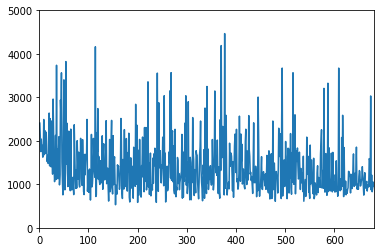

In [8]:
# compare image results and get the one closes to the median

from skimage import io
from skimage.metrics import structural_similarity as ssim

model_names = [f for f in os.listdir(path_models) if f.endswith('.pkl') and 'deblur' in f]
model_names.sort(key=custom_sort)

# get stats of predictions and GT

Nmodels= len(model_names)
model_idx = np.linspace(1,Nmodels,Nmodels)


# crop image GT and reference

gt_img  = pixelwise_median


# SSIM

y = np.empty_like(model_idx)
y[:] = np.nan


fig, ax = plt.subplots()
line, = ax.plot(model_idx, y) 
ax.set_xlim(0, Nmodels+1)
ax.set_ylim(0.0, 5000.0)


# Calculate for each model
#for idx, model_name in tqdm(enumerate(model_names), desc="Processing models", unit="model"): 
for idx, model_name in enumerate(model_names): 
    # open result
    base_name, extension = os.path.splitext(model_name)
    outName = outdir+base_name+'.tif';
    res_img  =  tifffile.imread(outName).astype(np.float32)   
   
    # Get ssim
    #ssim_value = ssim(gt_img, res_img, gaussian_weights=True) 
    error = np.sqrt(np.mean((gt_img - res_img)**2)) # RMSE   
    #print(error)
    y[idx] = error

    # Update the plot
    line.set_ydata(y)

    clear_output(wait=True)  # Clear the previous plot
    display(fig)
    
    # Close the figure when the loop is done
    plt.close(fig)
    #print(a_pred)
    

In [9]:
print(error)

953.2707077088531


In [12]:
# Get min simm

max_value = np.min(y)
max_index = np.argmin(y)
base_name, extension = os.path.splitext(model_names[max_index])

print("Maximum Value:", max_value)
print("Index of Maximum Value:", max_index)
print("Model Maximum Value:", model_names[max_index])

outName = img_src_path+outsufix+'_gt.tif';
tifffile.imwrite(outName,gt_img)

outName = img_src_path+outsufix+'_raw.tif';
tifffile.imwrite(outName,raw_img)

outName = outdir+base_name+'.tif'; 
res_img  =  tifffile.imread(outName) #.astype(np.float32)   
outName = img_src_path+outsufix+'_pred_'+base_name+'.tif';
tifffile.imwrite(outName,res_img)


Maximum Value: 530.2526179878631
Index of Maximum Value: 154
Model Maximum Value: deblur_net_16_36000.pkl
